In [1]:
import pandas as pd
import mdtraj as md
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from __future__ import print_function
import seaborn as sns
from matplotlib.ticker import NullFormatter, MaxNLocator
from pandas.plotting import scatter_matrix
import matplotlib.ticker as ticker
#import plotly.graph_objects as go
import scipy as sp
from itertools import chain, combinations
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import spatial
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
import scipy.stats as stats
#import statsmodels.stats.weightstats
from matplotlib import path
import matplotlib
from scipy.stats import probplot,shapiro, sem
#import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.linear_model import RidgeCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler

from matplotlib import cm
from collections import Counter
from numpy import linspace
#import umap.umap_ as umap
#import pylab
import os
#import PIL
from scipy.ndimage import gaussian_filter, uniform_filter1d

In [2]:
# import soursop
import afrc
import soursop
import MDAnalysis
import pandas as pd
import numpy as np
from soursop.sstrajectory import SSTrajectory
from Bio.PDB import *
from itertools import chain
import h5py

In [3]:
print("MAKE SURE afrc_venv_ virtual environment is enabled with conda")
print("MAKE SURE python version is 3.9.18")
import sys
sys.version

MAKE SURE afrc_venv_ virtual environment is enabled with conda
MAKE SURE python version is 3.9.18


'3.9.18 (main, Jan 26 2024, 16:04:25) \n[GCC 8.5.0 20210514 (Red Hat 8.5.0-20)]'

# Some Functions

In [4]:
def RSA_based_fC(protein_var,protein_name,poly_id,
                       GW_moment_var,every_ith_snap,GW_every_ith_snap,radius_):
    x_total=[]
    y_total=[]
    if poly_id=='protein':
        protein_label=protein_name
        temp_protein=protein_var.copy()
        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)
        x_total=list(chain.from_iterable(x_total))
        y_total=list(chain.from_iterable(y_total))
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein
    else:
        return print('ERROR')

    GW_po=GW_moment_var[['ratio','RSA']][::GW_every_ith_snap].copy()
    GW_po['polymer_id']=np.repeat('GW',GW_po.shape[0])
    
    #calculate mean and stdev values (must keep same mean and stdev values)
    upto_snapshots=1000000
    GW_mean_ratio=np.mean(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_std_ratio=np.std(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_mean_RSA=np.mean(GW_po['RSA'].values[0:(upto_snapshots+1)])
    GW_std_RSA=np.std(GW_po['RSA'].values[0:(upto_snapshots+1)])
        
    combined_pro_po=pd.concat([GW_po,protein_pro],axis=0,ignore_index=True)
    combined_pro_po['stdd_ratio']=(combined_pro_po['ratio'].values-GW_mean_ratio)/(GW_std_ratio)
    combined_pro_po['stdd_RSA']=(combined_pro_po['RSA'].values-GW_mean_RSA)/(GW_std_RSA)
    po_x=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_RSA'].values
    po_y=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_ratio'].values
    pro_x=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_RSA'].values
    pro_y=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_ratio'].values
    
    GW_points=np.c_[po_x, po_y]
    protein_points=np.c_[pro_x, pro_y]    
    tree_GW=spatial.cKDTree(GW_points)
    tree_protein=spatial.cKDTree(protein_points)

    GW_not_in_range=[]
    j=0
    for point in GW_points:

        if not tree_protein.query_ball_point(point,radius_):
            GW_not_in_range.append(point)
        j+=1
        if j%100000==0:
            print(f'{j} GW snapshots completed')
                
    fC_by_distance=(GW_points.shape[0]-len(GW_not_in_range))/(GW_points.shape[0])
    return fC_by_distance    


In [5]:
def RSA_Rs_protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= 'RSA'
    y_variable=r'$R_s$'
    global fC_value, grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]


    x_polmodel_GW.append(testeq_GW['RSA'].values)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)

        fC_value=RSA_based_fC(temp_protein,
                       protein_label,
                       second_obj,testeq_GW,
                       temp_protein.shape[0],
                       1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=1
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['RSA'].max()>max_x_val or testeq_GW['RSA'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    axTemperature.text(0.7,0.8,
                       '$f_C$= '+format(fC_value,'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



In [6]:
def protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= r'$R_g\left/R_g^{theta}\right.$' 
    y_variable=r'$R_s$'
    global grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]

    GW_rg = testeq_GW['Rg2']**0.5
    GW_rg_mean = GW_rg.mean()
    GW_rg_by_rg_mean = GW_rg/GW_rg_mean
    testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean
    
    x_polmodel_GW.append(GW_rg_by_rg_mean)
    y_polmodel_GW.append(testeq_GW['ratio'].values)
    
    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein['Rg/Rg_theta'].values)
        y_total.append(temp_protein.ratio.values)

        # fC_value=RSA_based_fC(temp_protein,
        #                protein_label,
        #                second_obj,testeq_GW,
        #                temp_protein.shape[0],
        #                1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=3
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['Rg/Rg_mean'].max()>max_x_val or testeq_GW['Rg/Rg_mean'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    # axTemperature.text(0.7,0.8,
    #                    '$f_C$= '+format(fC_value,'0.3f'),
    #                   transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



# generate a dataframe connecting directory with seq_name in their property df

In [7]:
seq_name_AFRC = pd.read_csv('../holehouse_project/IDRome_shape_mean_size_mean_added.csv')

In [8]:
seq_name_dir_df = pd.read_csv('../larsen_paper_2023_compaction/seq_name_dir_df.csv')
seq_name_dir_df

,seq_name,seq_dir,protein_uniprot_id
0,H0YL14_1_46,IDROME_larsen/IDRome_v4/H0/YL/14/1_46,H0YL14
1,H0YL09_1_131,IDROME_larsen/IDRome_v4/H0/YL/09/1_131,H0YL09
2,H0YKK7_1_89,IDROME_larsen/IDRome_v4/H0/YK/K7/1_89,H0YKK7
3,H0YKK7_135_164,IDROME_larsen/IDRome_v4/H0/YK/K7/135_164,H0YKK7
4,H0YKK7_430_550,IDROME_larsen/IDRome_v4/H0/YK/K7/430_550,H0YKK7
...,...,...,...
28053,A3QJZ6_111_153,IDROME_larsen/IDRome_v4/A3/QJ/Z6/111_153,A3QJZ6
28054,A3QJZ7_106_152,IDROME_larsen/IDRome_v4/A3/QJ/Z7/106_152,A3QJZ7
28055,A3KN83_1001_1044,IDROME_larsen/IDRome_v4/A3/KN/83/1001_1044,A3KN83
28056,A3KN83_1_250,IDROME_larsen/IDRome_v4/A3/KN/83/1_250,A3KN83


In [9]:
seq_name_AFRC

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,z_omega_+,z_omega_-,z_omega_h,fdomain,nu_svr,SPR_svr,AFRC_mean_rg_theta,rg_rg_theta_mean,mean_inst_ratio,mean_RSA
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,...,0.000000,0.000000,-0.531910,0.000000,0.565,10.288,15.191941,1.057621,5.808555,0.442952
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,...,-0.043142,0.000000,0.061436,0.000000,0.532,10.107,14.102458,1.026155,5.598546,0.408551
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,...,0.384885,2.281943,1.092688,0.298507,0.537,10.167,20.524202,1.094369,5.764964,0.403545
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,...,0.799692,0.000000,0.627563,0.000000,0.509,10.018,28.732651,1.057445,5.766837,0.365432
4,A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,...,1.947253,0.000000,0.090132,0.369565,0.578,10.316,17.085913,1.100872,6.130355,0.438200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,...,-1.319891,0.000000,0.163169,0.000000,0.520,9.993,33.590806,1.128366,5.388851,0.391268
28054,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,...,-2.182869,0.000000,2.214949,0.000000,0.537,9.984,39.658059,1.156510,5.803936,0.394400
28055,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,...,0.451957,2.132808,1.114749,0.513761,0.513,10.072,25.880343,1.164103,5.738483,0.426205
28056,W6CW81_1_113,W6CW81,113,0.519,10.084249,6.191149,0.843169,0.193880,2.943990,6.975229,...,0.554013,2.234693,-1.942090,0.451327,0.512,10.063,26.561695,1.108354,5.813349,0.400844


# write function

In [10]:
def compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    protein_rg_theta = seq_name_AFRC[seq_name_AFRC.seq_name==seq_name].AFRC_mean_rg_theta.values[0]
    #convert nm to angstrom for lindorff-larsen data
    protein_rg_by_rg_theta = (np.load(f'{example_protein_dir}/rg.npy')*10)/protein_rg_theta
    protein_df = pd.DataFrame(zip(np.load(f'{example_protein_dir}/rg.npy')**2,
                                 protein_rg_by_rg_theta),columns=['Rg2','Rg/Rg_theta']).copy()
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [11]:
def RSA_Rs_compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments
    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return RSA_Rs_protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [12]:
def load_trajectory(seq_name):
    #https://soursop.readthedocs.io/en/latest/usage/overview.html
    from soursop.sstrajectory import SSTrajectory
    global t_md, t_soursop,ree
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t_md = md.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc', 
                   top=f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
    t_soursop = SSTrajectory(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc',
                             f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
    ree = np.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/ete.npy')
    ProtObj = t_soursop.proteinTrajectoryList[0]
    return ProtObj


In [13]:
#Rij is from lindorff-larsen
def Rij(traj):
    pairs = traj.top.select_pairs('all','all')
    d = md.compute_distances(traj,pairs)
    nres = traj.n_atoms
    ij = np.arange(2,nres,1)
    diff = [x[1]-x[0] for x in pairs]
    dij = np.empty(0)
    for i in ij:
        dij = np.append(dij,np.sqrt((d[:,diff==i]**2).mean().mean()))
    f = lambda x,R0,v : R0*np.power(x,v)
    popt, pcov = curve_fit(f,ij[ij>5],dij[ij>5],p0=[.4,.5])
    nu = popt[1]
    nu_err = pcov[1,1]**0.5
    R0 = popt[0]
    R0_err = pcov[0,0]**0.5
    return ij,dij,nu,nu_err,R0,R0_err

def calculate_nu_KLL_from_seq_name(seq_name, start_residue, end_residue):
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name == seq_name].seq_dir.values[0]
    t_md = md.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc', 
                   top=f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
    # Skipping the first 10 frames
    t_md = t_md[10:]
    subsequence_indices = t_md.topology.select(f'residue {start_residue-1} to {end_residue-1}')
    
    subsequence_traj = t_md.atom_slice(subsequence_indices)

    ij, dij, nu, nu_err, R0, R0_err = Rij(subsequence_traj)
    return nu, nu_err

#original lindorff-larsen code,keeping as reference (Rij is original function from their github)
# def calculate_nu_KLL(seq_name):
#     example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
#     t_md = md.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc', 
#                    top=f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
#     ij,dij,nu,nu_err,R0,R0_err = Rij(t_md)
#     return nu

# def Rij(traj):
#     pairs = traj.top.select_pairs('all','all')
#     d = md.compute_distances(traj,pairs)
#     nres = traj.n_atoms
#     ij = np.arange(2,nres,1)
#     diff = [x[1]-x[0] for x in pairs]
#     dij = np.empty(0)
#     for i in ij:
#         dij = np.append(dij,np.sqrt((d[:,diff==i]**2).mean().mean()))
#     f = lambda x,R0,v : R0*np.power(x,v)
#     popt, pcov = curve_fit(f,ij[ij>5],dij[ij>5],p0=[.4,.5])
#     nu = popt[1]
#     nu_err = pcov[1,1]**0.5
#     R0 = popt[0]
#     R0_err = pcov[0,0]**0.5
#     return ij,dij,nu,nu_err,R0,R0_err

In [14]:
#master_df = master_df.reset_index(drop=True).copy()

# use  pyconformap shape vs size

In [15]:
exec(open("../larsen_paper_2023_compaction/pyconformap_modified.py").read())
def generate_2d_map(seq_name):
    location_of_files = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]    
    rg2_value = np.load(location_of_files+'/rg.npy')**2
    ree2_value = np.load(location_of_files+'/ete.npy')**2
    pd.DataFrame(zip(rg2_value,ree2_value),columns=['Rg2','Ree2']).to_csv(seq_name+'.csv',index=False)
    map_2d_seq_name = PyConforMap(seq_name+'.csv')
    map_2d_seq_name.plot_protein_against_GW(seq_name+'.csv')
    os.remove(seq_name+'.csv')
    return 

# combine the df


In [17]:
seq_name_fluctations = pd.read_csv('../larsen_paper_2023_compaction/HPC_computed_fC_values_all.csv').set_index('seq_name_list')
seq_stdev = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_stdev.csv').set_index('seq_name')
seq_ALBATROSS = pd.read_csv('../holehouse_project/IDRome_with_ALBATROSS_calculations.csv').set_index('seq_name')
seq_ranges = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_range.csv').set_index('seq_name')
seq_Rs_RSA_min_max = pd.read_csv('../holehouse_project/IDRome_Rs_RSA_min_max.csv').set_index('seq_name')
seq_Rs_12_frac = pd.read_csv('../holehouse_project/IDRome_Rs_frac_greater_than_12.csv').set_index('seq_name')
subchain_metrics = pd.read_csv('./subchain_metrics_df_combined.csv').set_index('seq_name')
# the bounded_frac_size_shape is only for size-shape (through pyconformap_modified)


#add fP to the property df
seq_name_AFRC['fP'] = [seq.count('P')/len(seq) for seq in seq_name_AFRC.fasta.values]


seq_name_AFRC['net_charge'] = [(seq.count('K')+seq.count('R')-seq.count('D')-seq.count('E'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['fpos'] = [(seq.count('K')+seq.count('R'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['fneg'] = [(seq.count('D')+seq.count('E'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['faliphatic'] = [(seq.count('I')+seq.count('L')+seq.count('M')+seq.count('V'))/len(seq) for seq in seq_name_AFRC.fasta.values]

idrome_prop_flucs = pd.concat([seq_name_AFRC.set_index('seq_name'),
           seq_name_fluctations[['fC_shape_shape',
                                 'fA_shape_shape',
                                 'fC_size_shape',
                                 'fA_size_shape',
                                 'bounded_frac_size_shape']],
                              seq_stdev[['Rg_std','Rs_std','RSA_std']],
                              seq_ALBATROSS[['albatross_Rg','albatross_Rg_scaled','albatross_Ree','albatross_Ree_scaled',
                                             'albatross_scaling_exponent']],
                              seq_ranges[['Rg_range','Rs_range','RSA_range']],
                              seq_Rs_RSA_min_max[['Rs_min','Rs_max','RSA_min','RSA_max']],
                              seq_Rs_12_frac[['Rs_frac']],subchain_metrics],
          axis=1).reset_index().rename(columns={'index':'seq_name'}).copy()

#compare global vs local subchain metrics
idrome_prop_flucs['glob_loc_fac_RSA'] = (idrome_prop_flucs['mean_RSA'].values-idrome_prop_flucs['min_mean_RSA'].values)/(idrome_prop_flucs['max_mean_RSA'].values-idrome_prop_flucs['min_mean_RSA'].values)
idrome_prop_flucs['glob_loc_fac_Rs'] = (idrome_prop_flucs['mean_inst_ratio'].values-idrome_prop_flucs['min_mean_Rs'].values)/(idrome_prop_flucs['max_mean_Rs'].values-idrome_prop_flucs['min_mean_Rs'].values)
idrome_prop_flucs['glob_loc_fac_rg_theta_mean'] = (idrome_prop_flucs['rg_rg_theta_mean'].values-idrome_prop_flucs['min_mean_rg_rg_theta'].values)/(idrome_prop_flucs['max_mean_rg_rg_theta'].values-idrome_prop_flucs['min_mean_rg_rg_theta'].values)

del seq_name_fluctations, seq_name_AFRC, seq_stdev, seq_ALBATROSS, seq_Rs_RSA_min_max,seq_Rs_12_frac,subchain_metrics
idrome_prop_flucs

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,mid_res_max_mean_rg_rg_theta,stdev_mean_rg_rg_theta,min_mean_nu,mid_res_min_mean_nu,max_mean_nu,mid_res_max_mean_nu,stdev_mean_nu,glob_loc_fac_RSA,glob_loc_fac_Rs,glob_loc_fac_rg_theta_mean
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,...,18.0,0.014482,0.604528,13.0,0.655475,18.0,0.013469,-1.379114,-1.384175,3.558144
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,...,12.0,0.014967,0.575042,18.0,0.645993,7.0,0.019511,-1.234030,-1.871938,2.175876
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,...,51.0,0.013978,0.524312,19.0,0.592436,47.0,0.024612,-0.038903,0.107637,1.418082
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,...,116.0,0.021404,0.518506,50.0,0.587438,113.0,0.019152,-0.750421,0.303032,0.536720
4,A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,...,22.0,0.017341,0.553039,32.0,0.645676,20.0,0.029551,-0.321009,0.334304,2.668049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,...,139.0,0.013574,0.542512,165.0,0.597604,85.0,0.015493,-0.643604,-0.265270,1.869392
28054,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,...,228.0,0.018465,0.554747,87.0,0.600955,142.0,0.010665,-0.642560,0.018576,1.633132
28055,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,...,46.0,0.019801,0.507268,16.0,0.624624,46.0,0.028998,0.237612,0.202796,1.801725
28056,W6CW81_1_113,W6CW81,113,0.519,10.084249,6.191149,0.843169,0.193880,2.943990,6.975229,...,72.0,0.018726,0.546651,41.0,0.577160,60.0,0.007601,-0.674768,-0.008696,1.290650


In [18]:
idrome_prop_flucs.columns

Index(['seq_name', 'UniProt_ID', 'N', 'nu', 'SPR', 'ete2_Rg2', 'S', 'Delta',
       'Rg/nm', 'Ree/nm', 'Rh/nm', 'fK', 'fR', 'fE', 'fD', 'faro',
       'mean_lambda', 'shd', 'scd', 'kappa', 'fcr', 'ncpr', 'fasta',
       'is_btw_folded', 'is_nterm', 'is_cterm', 'is_idp', 'first', 'last',
       'N_FL', 'protein_name', 'gene_name', 'QCDpred', 'z_delta_+-',
       'z_omega_pi', 'z_omega_+', 'z_omega_-', 'z_omega_h', 'fdomain',
       'nu_svr', 'SPR_svr', 'AFRC_mean_rg_theta', 'rg_rg_theta_mean',
       'mean_inst_ratio', 'mean_RSA', 'fP', 'net_charge', 'fpos', 'fneg',
       'faliphatic', 'fC_shape_shape', 'fA_shape_shape', 'fC_size_shape',
       'fA_size_shape', 'bounded_frac_size_shape', 'Rg_std', 'Rs_std',
       'RSA_std', 'albatross_Rg', 'albatross_Rg_scaled', 'albatross_Ree',
       'albatross_Ree_scaled', 'albatross_scaling_exponent', 'Rg_range',
       'Rs_range', 'RSA_range', 'Rs_min', 'Rs_max', 'RSA_min', 'RSA_max',
       'Rs_frac', 'window_size', 'min_mean_Rg', 'mid_res_min_m

### DO NOT RUN the immediately below cell

In [16]:
#DO NOT run this cell
#these FOUR IDR simulations have low snapshots (<1000)
# %%time
# for seq_dir in seq_name_dir_df.seq_dir.values:
#     if np.load(seq_dir+'/rg.npy').shape[0]!=1000:
#         print(seq_name_dir_df[seq_name_dir_df.seq_dir==seq_dir].seq_name, np.load(seq_dir+'/rg.npy').shape[0])

3703    Q53SF7_218_1128
Name: seq_name, dtype: object 500
11700    Q7Z2Y5_341_1224
Name: seq_name, dtype: object 420
23881    Q9Y2W1_1_611
Name: seq_name, dtype: object 100
27365    Q9BXT5_1_968
Name: seq_name, dtype: object 100
CPU times: user 3.77 s, sys: 2.96 s, total: 6.73 s
Wall time: 14min 48s


In [19]:
#drop these FOUR IDR simulations because of low snapshots #
seq_name_dir_df = seq_name_dir_df[~seq_name_dir_df.seq_name.isin(['Q53SF7_218_1128',
                                             'Q7Z2Y5_341_1224',
                                             'Q9Y2W1_1_611',
                                             'Q9BXT5_1_968'])].copy()

idrome_prop_flucs = idrome_prop_flucs[~idrome_prop_flucs.seq_name.isin(['Q53SF7_218_1128',
                                             'Q7Z2Y5_341_1224',
                                             'Q9Y2W1_1_611',
                                             'Q9BXT5_1_968'])].copy()

## additional functions for visualization

In [20]:
def compute_30mer_data_from_seq_name(seq_name,k_frac, h5_file_path):
    print('using 30 as moving window size, constant, based on protein of smallest length')
    print('for proteins of length more than 60, moving window size = 30')
    print('for proteins of length less than or equal to 60, moving window size = 1/k_frac of length')
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    
    traj = md.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc',
                   top=f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
    
    fasta_sequence = idrome_prop_flucs[idrome_prop_flucs.seq_name==seq_name].fasta.values[0]
    
    # Skipping the first 10 frames
    traj = traj[10:]    
    
    # Set the subsequence length k (replace 4 with your desired value)
    n_residues = traj.topology.n_residues

    if len(fasta_sequence) <= 60:
        k = round(traj.topology.n_residues/k_frac)
    elif len(fasta_sequence) > 60:
        k = 30

    with h5py.File(h5_file_path, 'a') as h5file:
        protein_group = h5file.create_group(seq_name)

        # Compute various properties for the whole protein
        complete_protein_rgyr = np.mean(md.compute_rg(traj))
        protein_group.create_dataset('full_protein_rgyr', data=complete_protein_rgyr)

        # store fasta sequence
        protein_group.create_dataset('fasta_sequence_whole_protein', data=fasta_sequence)

        # store seq_name
        protein_group.create_dataset('seq_name', data=seq_name)
        
        first_bead_index = traj.topology.select(f"residue {0}")[0]
        last_bead_index = traj.topology.select(f"residue {n_residues - 1}")[0]    
        end_to_end_distances = md.compute_distances(traj, [[first_bead_index, last_bead_index]])
        end_to_end_distances = end_to_end_distances.flatten()
        complete_protein_ete = end_to_end_distances
        complete_protein_inst_ratio = np.mean((complete_protein_ete**2)/(complete_protein_rgyr**2))
        protein_group.create_dataset('full_protein_ratio', data=complete_protein_inst_ratio)
    
        complete_protein_moments = pd.DataFrame(md.principal_moments(traj),columns=['R3','R2','R1']).copy()
        complete_protein_moments['asphericity']=complete_protein_moments.R1.values-(0.5*(complete_protein_moments.R2.values+complete_protein_moments.R3.values))
        complete_protein_moments['acylindricity']=complete_protein_moments.R2.values-complete_protein_moments.R3.values
        complete_protein_moments['RSA']=(complete_protein_moments.asphericity.values**2+(0.75*complete_protein_moments.acylindricity.values**2))/(complete_protein_moments.R1.values+complete_protein_moments.R2.values+complete_protein_moments.R3.values)**2
        complete_protein_RSA = np.mean(complete_protein_moments['RSA'].values)    
        protein_group.create_dataset('full_protein_RSA', data=complete_protein_RSA)

        #AFRC
        complete_protein_afrc_init = afrc.AnalyticalFRC(fasta_sequence)
        complete_protein_rg_theta_mean = complete_protein_afrc_init.get_mean_radius_of_gyration()
        complete_protein_rg_rg_theta_mean = np.mean((10*md.compute_rg(traj))/complete_protein_rg_theta_mean)
        protein_group.create_dataset('full_protein_rg_rg_theta_mean', data=complete_protein_rg_rg_theta_mean)

        #nu
        complete_protein_nu = calculate_nu_KLL_from_seq_name(seq_name, 1, n_residues)[0]
        complete_protein_nu_err = calculate_nu_KLL_from_seq_name(seq_name, 1, n_residues)[1]
        protein_group.create_dataset('full_protein_nu_recompute', data=complete_protein_nu)
        protein_group.create_dataset('full_protein_nu_recompute_err', data=complete_protein_nu_err)
    
        j = 0
        seq_name_list = []
        k_list = []
        mid_residue = []
        subchain_mean_Rg = []
        subchain_mean_Rs = []
        subchain_mean_RSA = []
        subchain_mean_rg_rg_theta = []
        subchain_nu = []
        
        # Iterate through each subsequence of k residues
        for start_res in range(1, n_residues - k + 2):  # Ensures we don't go out of bounds
            seq_name_list.append(seq_name)
            k_list.append(k)
            # Select k consecutive residues
            subsequence_group = protein_group.create_group(f'mer_{start_res}_{start_res + k - 1}')
            selection_string = f"residue {start_res-1} to {start_res + k - 2}"  # MDTraj is zero-indexed

            mid_residue.append(((start_res-1) + (start_res + k - 2) ) //2 )

            
            subsequence_indices = traj.topology.select(selection_string)
            
            fasta_slice = fasta_sequence[(start_res-1):(start_res + k - 1)]
            subsequence_group.create_dataset('fasta_subsequence', data=fasta_slice)
            subsequence_group.create_dataset('selection_string', data=selection_string)
            
            
            # Create a trajectory slice for the selected subsequence
            subsequence_traj = traj.atom_slice(subsequence_indices)
            
            # Calculate the radius of gyration for the subsequence over all remaining frames
            rgyr = md.compute_rg(subsequence_traj)
            subsequence_group.create_dataset('Rg/nm', data=rgyr)
            subchain_mean_Rg.append(np.mean(rgyr))
            
            #calculate nu
            subsequence_nu = calculate_nu_KLL_from_seq_name(seq_name, start_res, start_res + k - 1)[0]
            subsequence_nu_err = calculate_nu_KLL_from_seq_name(seq_name, start_res, start_res + k - 1)[1]
            subsequence_group.create_dataset('nu_recompute', data=subsequence_nu)
            subsequence_group.create_dataset('nu_recompute_err', data=subsequence_nu_err)
            subchain_nu.append(subsequence_nu)
            
            # Select indices for the first and last bead in the subsequence for end-to-end distance calculation
            first_bead_index = traj.topology.select(f"residue {start_res-1}")[0]
            last_bead_index = traj.topology.select(f"residue {start_res + k - 2}")[0]
        
            # Calculate end-to-end distances for the subsequence over all remaining frames
            end_to_end_distances = md.compute_distances(traj, [[first_bead_index, last_bead_index]])
            end_to_end_distances = end_to_end_distances.flatten()
            subsequence_group.create_dataset('ete', data=end_to_end_distances)
            
            running_inst_ratio = (end_to_end_distances**2)/(rgyr**2)
            subsequence_group.create_dataset('inst_ratio', data=running_inst_ratio)
            subchain_mean_Rs.append(np.mean(running_inst_ratio))
            
            t_df_moments = pd.DataFrame(md.principal_moments(subsequence_traj),columns=['R3','R2','R1']).copy()
            t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
            t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
            t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
            subsequence_group.create_dataset('RSA', data=t_df_moments['RSA'].values)
            subchain_mean_RSA.append(np.mean(t_df_moments['RSA'].values))
    
            #AFRC
            afrc_init = afrc.AnalyticalFRC(fasta_slice)
            rg_theta_mean = afrc_init.get_mean_radius_of_gyration()
            rg_rg_theta_mean = (10*rgyr) / rg_theta_mean
            subsequence_group.create_dataset('rg_rg_theta_mean', data=rg_rg_theta_mean)
            subchain_mean_rg_rg_theta.append(np.mean(rg_rg_theta_mean))
        global combined_subchain_metrics
        combined_subchain_metrics = pd.DataFrame(zip(seq_name_list,k_list,mid_residue,subchain_mean_Rg,subchain_mean_Rs,subchain_mean_RSA,
                                                subchain_mean_rg_rg_theta,subchain_nu),
                                             columns = ['seq_name','window_size','mid_residue','mean_Rg','mean_Rs','mean_RSA',
                                                'mean_rg_rg_theta','nu'])
        #Rg metrics
        min_mean_Rg = [combined_subchain_metrics.mean_Rg.min()]
        mid_res_min_mean_Rg = [combined_subchain_metrics[combined_subchain_metrics.mean_Rg == combined_subchain_metrics.mean_Rg.min()].mid_residue.values[0]]
        max_mean_Rg = [combined_subchain_metrics.mean_Rg.max()]
        mid_res_max_mean_Rg = [combined_subchain_metrics[combined_subchain_metrics.mean_Rg == combined_subchain_metrics.mean_Rg.max()].mid_residue.values[0]]
        stdev_mean_Rg = [combined_subchain_metrics.mean_Rg.std()]

        #Rs metrics
        min_mean_Rs = [combined_subchain_metrics.mean_Rs.min()]
        mid_res_min_mean_Rs = [combined_subchain_metrics[combined_subchain_metrics.mean_Rs == combined_subchain_metrics.mean_Rs.min()].mid_residue.values[0]]
        max_mean_Rs = [combined_subchain_metrics.mean_Rs.max()]
        mid_res_max_mean_Rs = [combined_subchain_metrics[combined_subchain_metrics.mean_Rs == combined_subchain_metrics.mean_Rs.max()].mid_residue.values[0]]
        stdev_mean_Rs = [combined_subchain_metrics.mean_Rs.std()]
        
        #RSA metrics
        min_mean_RSA = [combined_subchain_metrics.mean_RSA.min()]
        mid_res_min_mean_RSA = [combined_subchain_metrics[combined_subchain_metrics.mean_RSA == combined_subchain_metrics.mean_RSA.min()].mid_residue.values[0]]
        max_mean_RSA = [combined_subchain_metrics.mean_RSA.max()]
        mid_res_max_mean_RSA = [combined_subchain_metrics[combined_subchain_metrics.mean_RSA == combined_subchain_metrics.mean_RSA.max()].mid_residue.values[0]]
        stdev_mean_RSA = [combined_subchain_metrics.mean_RSA.std()]
        
        #rg_rg_theta metrics
        min_mean_rg_rg_theta = [combined_subchain_metrics.mean_rg_rg_theta.min()]
        mid_res_min_mean_rg_rg_theta = [combined_subchain_metrics[combined_subchain_metrics.mean_rg_rg_theta == combined_subchain_metrics.mean_rg_rg_theta.min()].mid_residue.values[0]]
        max_mean_rg_rg_theta = [combined_subchain_metrics.mean_rg_rg_theta.max()]
        mid_res_max_mean_rg_rg_theta = [combined_subchain_metrics[combined_subchain_metrics.mean_rg_rg_theta == combined_subchain_metrics.mean_rg_rg_theta.max()].mid_residue.values[0]]
        stdev_mean_rg_rg_theta = [combined_subchain_metrics.mean_rg_rg_theta.std()]
        
        #nu metrics
        min_mean_nu = [combined_subchain_metrics.nu.min()]
        mid_res_min_mean_nu = [combined_subchain_metrics[combined_subchain_metrics.nu == combined_subchain_metrics.nu.min()].mid_residue.values[0]]
        max_mean_nu = [combined_subchain_metrics.nu.max()]
        mid_res_max_mean_nu = [combined_subchain_metrics[combined_subchain_metrics.nu == combined_subchain_metrics.nu.max()].mid_residue.values[0]]
        stdev_mean_nu = [combined_subchain_metrics.nu.std()]
        
        #generate dataframe of chosen subchain metrics
        selected_subchain_metrics = pd.DataFrame(zip([combined_subchain_metrics.seq_name.unique()[0]],[combined_subchain_metrics.window_size.unique()[0]],
            min_mean_Rg,mid_res_min_mean_Rg,max_mean_Rg,mid_res_max_mean_Rg,stdev_mean_Rg,
                                                    min_mean_Rs,mid_res_min_mean_Rs,max_mean_Rs,mid_res_max_mean_Rs,stdev_mean_Rs,
                                                    min_mean_RSA,mid_res_min_mean_RSA,max_mean_RSA,mid_res_max_mean_RSA,stdev_mean_RSA,
                        min_mean_rg_rg_theta,mid_res_min_mean_rg_rg_theta,max_mean_rg_rg_theta,mid_res_max_mean_rg_rg_theta,stdev_mean_rg_rg_theta,
                                            min_mean_nu,mid_res_min_mean_nu,max_mean_nu,mid_res_max_mean_nu,stdev_mean_nu),
                                                 columns=['seq_name','window_size',
                                                 'min_mean_Rg','mid_res_min_mean_Rg','max_mean_Rg','mid_res_max_mean_Rg','stdev_mean_Rg',
                                                         'min_mean_Rs','mid_res_min_mean_Rs','max_mean_Rs','mid_res_max_mean_Rs','stdev_mean_Rs',
                                                'min_mean_RSA','mid_res_min_mean_RSA','max_mean_RSA','mid_res_max_mean_RSA','stdev_mean_RSA',
            'min_mean_rg_rg_theta','mid_res_min_mean_rg_rg_theta','max_mean_rg_rg_theta','mid_res_max_mean_rg_rg_theta','stdev_mean_rg_rg_theta',
                                            'min_mean_nu','mid_res_min_mean_nu','max_mean_nu','mid_res_max_mean_nu','stdev_mean_nu'])
        print('ALL DONE')    
    return selected_subchain_metrics

In [21]:
def compute_30mer_data_from_seq_name_no_hdf5(seq_name,k_frac):
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    
    traj = md.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc',
                   top=f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
    
    fasta_sequence = idrome_prop_flucs[idrome_prop_flucs.seq_name==seq_name].fasta.values[0]
    
    # Skipping the first 10 frames
    traj = traj[10:]    
    
    # Set the subsequence length k (replace 4 with your desired value)
    n_residues = traj.topology.n_residues

    if len(fasta_sequence) <= 60:
        k = round(traj.topology.n_residues/k_frac)
    elif len(fasta_sequence) > 60:
        k = 30


    complete_protein_rgyr = np.mean(md.compute_rg(traj))
    complete_protein_nu = calculate_nu_KLL_from_seq_name(seq_name, 1, n_residues)[0]
    complete_protein_nu_err = calculate_nu_KLL_from_seq_name(seq_name, 1, n_residues)[1]
    first_bead_index = traj.topology.select(f"residue {0}")[0]
    last_bead_index = traj.topology.select(f"residue {n_residues - 1}")[0]    
    end_to_end_distances = np.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/ete.npy')
    complete_protein_ete = end_to_end_distances
    complete_protein_inst_ratio = np.mean(complete_protein_ete**2/np.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/rg.npy')**2)
    
    complete_protein_moments = pd.DataFrame(md.principal_moments(traj),columns=['R3','R2','R1']).copy()
    complete_protein_moments['asphericity']=complete_protein_moments.R1.values-(0.5*(complete_protein_moments.R2.values+complete_protein_moments.R3.values))
    complete_protein_moments['acylindricity']=complete_protein_moments.R2.values-complete_protein_moments.R3.values
    complete_protein_moments['RSA']=(complete_protein_moments.asphericity.values**2+(0.75*complete_protein_moments.acylindricity.values**2))/(complete_protein_moments.R1.values+complete_protein_moments.R2.values+complete_protein_moments.R3.values)**2
    complete_protein_RSA = np.mean(complete_protein_moments['RSA'].values)    

    #AFRC
    complete_protein_afrc_init = afrc.AnalyticalFRC(fasta_sequence)
    complete_protein_rg_theta_mean = complete_protein_afrc_init.get_mean_radius_of_gyration()
    complete_protein_rg_rg_theta_mean = np.mean((10*md.compute_rg(traj))/complete_protein_rg_theta_mean)

    
    j = 0
    # Iterate through each subsequence of k residues
    for start_res in range(1, n_residues - k + 2):  # Ensures we don't go out of bounds
        # Select k consecutive residues
        selection_string = f"residue {start_res-1} to {start_res + k - 2}"  # MDTraj is zero-indexed
        subsequence_indices = traj.topology.select(selection_string)
        
        fasta_slice = fasta_sequence[(start_res-1):(start_res + k - 1)]
        running_df = pd.DataFrame(np.repeat(fasta_slice,traj.n_frames),columns=['fasta_sequence'])
        running_df['start_res_zeroindex'] = np.repeat(start_res-1,traj.n_frames)
        running_df['end_res_zeroindex'] = np.repeat(start_res + k - 2,traj.n_frames)
        running_df['full_protein_fasta'] = np.repeat(fasta_sequence,traj.n_frames)

        running_df['full_protein_rgyr'] = np.repeat(complete_protein_rgyr,traj.n_frames)
        running_df['full_protein_nu_recompute'] = np.repeat(complete_protein_nu,traj.n_frames)
        running_df['full_protein_nu_recompute_err'] = np.repeat(complete_protein_nu_err,traj.n_frames)
        running_df['full_protein_ratio'] = np.repeat(complete_protein_inst_ratio,traj.n_frames)
        running_df['full_protein_RSA'] = np.repeat(complete_protein_RSA,traj.n_frames)
        running_df['full_protein_rg_rg_theta_mean'] = np.repeat(complete_protein_rg_rg_theta_mean,traj.n_frames)
        
        running_df['seq_name'] = np.repeat(seq_name,traj.n_frames)
        # Create a trajectory slice for the selected subsequence
        subsequence_traj = traj.atom_slice(subsequence_indices)
        
        # Calculate the radius of gyration for the subsequence over all remaining frames
        rgyr = md.compute_rg(subsequence_traj)
        running_df['Rg/nm'] = rgyr

        #calculate nu
        subsequence_nu = calculate_nu_KLL_from_seq_name(seq_name, start_res, start_res + k - 1)[0]
        subsequence_nu_err = calculate_nu_KLL_from_seq_name(seq_name, start_res, start_res + k - 1)[1]
        running_df['nu_recompute'] = np.repeat(subsequence_nu,traj.n_frames)
        running_df['nu_recompute_err'] = np.repeat(subsequence_nu_err,traj.n_frames)
        
        # Select indices for the first and last bead in the subsequence for end-to-end distance calculation
        first_bead_index = traj.topology.select(f"residue {start_res-1}")[0]
        last_bead_index = traj.topology.select(f"residue {start_res + k - 2}")[0]
    
        # Calculate end-to-end distances for the subsequence over all remaining frames
        end_to_end_distances = md.compute_distances(traj, [[first_bead_index, last_bead_index]])
        end_to_end_distances = end_to_end_distances.flatten()
        running_df['ete'] = end_to_end_distances
        running_df['inst_ratio'] = (running_df['ete'].values**2)/(running_df['Rg/nm'].values**2)
        
        t_df_moments = pd.DataFrame(md.principal_moments(subsequence_traj),columns=['R3','R2','R1']).copy()
        t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
        t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
        t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
        running_df['RSA'] = t_df_moments['RSA'].values

        #AFRC
        afrc_init = afrc.AnalyticalFRC(fasta_slice)
        rg_theta_mean = afrc_init.get_mean_radius_of_gyration()
        running_df['AFRC_mean_rg_theta'] = np.repeat(rg_theta_mean,traj.n_frames)
        running_df['rg_rg_theta_mean'] = (10*running_df['Rg/nm'].values)/running_df['AFRC_mean_rg_theta'].values
        
        if j == 0:
            master_df = running_df.copy()
        elif j>0:
            master_df = pd.concat([master_df,running_df],axis=0).copy()
        del running_df, t_df_moments
        print(f"residue {start_res-1} to {start_res + k - 2} done")
        j+=1
    print('ALL DONE')    
    return master_df

In [22]:
def plot_protein_composition(seq_name):
    protein_sequence = idrome_prop_flucs[idrome_prop_flucs.seq_name==seq_name].fasta.values[0]
    # Define the groups and their respective amino acids
    groups = {
        'Negative (E/D)': ['E', 'D'],
        'Positive (R/K)': ['R', 'K'],
        'Proline (P)': ['P'],
        'Aromatic (Y/F/W)': ['Y', 'F', 'W'],
        'Aliphatic (I/L/M/V)': ['I', 'L', 'M', 'V']
    }
    
    # Colors corresponding to each group, including 'Uncategorized'
    colors = {
        'Negative (E/D)': 'red',
        'Positive (R/K)': 'blue',
        'Proline (P)': 'purple',
        'Aromatic (Y/F/W)': 'yellow',
        'Aliphatic (I/L/M/V)': 'grey',
        'Uncategorized': 'lightgrey'
    }
    
    # Count the frequency of each group in the sequence
    group_count = {group: 0 for group in groups}
    categorized_count = 0  # Track categorized residues to find uncategorized ones

    for aa in protein_sequence:
        found = False
        for group, aas in groups.items():
            if aa in aas:
                group_count[group] += 1
                categorized_count += 1
                found = True
                break
        if not found:
            group_count.setdefault('Uncategorized', 0)
            group_count['Uncategorized'] += 1
    
    # Prepare data for the pie chart
    labels = [group for group in group_count if group_count[group] > 0]
    sizes = [group_count[group] for group in labels]
    plot_colors = [colors[label] for label in labels]
    
    # Create pie chart
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct=lambda pct: f"{pct:.1f}%", startangle=90, colors=plot_colors)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


In [23]:
def assign_properties(residue):
    properties = {
        'negative': ['E', 'D'],
        'positive': ['R', 'K'],
        'apolar': ['Y', 'F','A', 'W','I', 'L', 'M', 'V','P','G','C'],
        'polar': ['S','T','Q','N','H']
    }
    colors = {
        'negative': 'red',
        'positive': 'blue',
        'apolar': 'yellow',
        'polar': 'white'  # Visibility adjustment with black edge
    }
    size = 0
    color = 'black'
    for prop, residues in properties.items():
        if residue in residues:
            color = colors[prop]
            size = 80  # Adjust size for visual distinction
            break
    return color, size
def subchain_Rg_plot(df,figwidth,figheight):
    # Calculate the midpoint for plotting and the properties for each midpoint
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]),
                                     axis=1, result_type='expand')
    
    # Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
    stats_rg = df.groupby('mid_residue').agg({
        'Rg/nm': ['mean', 'std'],
        'color': lambda x: x.mode()[0],
        'size': lambda x: x.mode()[0]
    }).reset_index()
    
    # Flatten the MultiIndex
    stats_rg.columns = ['mid_residue', 'mean', 'std', 'color', 'size']

    fig, ax = plt.subplots(figsize=(figwidth, figheight))
    
    # Plotting
    ax.plot(stats_rg['mid_residue'], stats_rg['mean'], color='black', zorder=1)
    ax.fill_between(stats_rg['mid_residue'], 
                     stats_rg['mean'] - (stats_rg['std']/2), 
                     stats_rg['mean'] + (stats_rg['std']/2), 
                     color='gray', alpha=0.2, zorder=1)
    global_var = df.full_protein_rgyr.unique()[0]
    if global_var>=np.min(ax.get_ylim()) and global_var<=np.max(ax.get_ylim()):
        ax.axhline(y=global_var, color='black', linestyle='--')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')
    else:
        fig.text(0.12, 0.879, f'Global <$R_g$> = {format(global_var, "0.2f")} nm',
                 fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold',pad = 22)
    
    # Adjust scatter plot to use different sizes and colors with higher zorder
    for i, row in stats_rg.iterrows():
        ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)
    
    ax.set_xlabel('Residue', fontsize=12)
    ax.set_ylabel('Local <$R_g$> (nm)', fontsize=12)
    
    
    # Customizing the plot border thickness
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
    ax.tick_params(axis='both', which='minor', width=0.6)
    
    # Create custom legend with circles and edge color for white patch
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Apolar (Y/F/A/W/I/L/M/V/P/G/C)', markersize=10, markerfacecolor='yellow',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Polar (S/T/Q/N/H)', markersize=10, markerfacecolor='white',
              markeredgewidth=1, markeredgecolor='black')  
    ]
    
    # Adding the legend with the custom entries
    ax.legend(handles=legend_elements, loc=(1.01,0.6))
    return 



In [24]:
def subchain_Rs_plot(df,figwidth,figheight):
    # Calculate the midpoint for plotting and the properties for each midpoint
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]),
                                     axis=1, result_type='expand')
    
    # Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
    stats_rs = df.groupby('mid_residue').agg({
        'inst_ratio': ['mean', 'std'],
        'color': lambda x: x.mode()[0],
        'size': lambda x: x.mode()[0]
    }).reset_index()
    
    # Flatten the MultiIndex
    stats_rs.columns = ['mid_residue', 'mean', 'std', 'color', 'size']
    
    fig, ax = plt.subplots(figsize=(figwidth,figheight))
    
    # Plotting
    ax.plot(stats_rs['mid_residue'], stats_rs['mean'], color='black', zorder=1)
    ax.fill_between(stats_rs['mid_residue'], 
                     stats_rs['mean'] - (stats_rs['std']/2), 
                     stats_rs['mean'] + (stats_rs['std']/2), 
                     color='gray', alpha=0.2, zorder=1)

    global_var = df.full_protein_ratio.unique()[0]
    if global_var>=np.min(ax.get_ylim()) and global_var<=np.max(ax.get_ylim()):
        ax.axhline(y=global_var, color='black', linestyle='--')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')
    else:
        fig.text(0.12, 0.879, f'Global <$R_s$> = {format(global_var, "0.2f")}',
                 fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold',pad = 22)
    
    # Adjust scatter plot to use different sizes and colors with higher zorder
    for i, row in stats_rs.iterrows():
        ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)
    
    ax.set_xlabel('Residue', fontsize=12)
    ax.set_ylabel('Local <$R_s$>', fontsize=12)
    
    
    # Customizing the plot border thickness
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
    ax.tick_params(axis='both', which='minor', width=0.6)
    
    # Create custom legend with circles and edge color for white patch
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Apolar (Y/F/A/W/I/L/M/V/P/G/C)', markersize=10, markerfacecolor='yellow',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Polar (S/T/Q/N/H)', markersize=10, markerfacecolor='white',
              markeredgewidth=1, markeredgecolor='black')  
    ]
    
    # Adding the legend with the custom entries
    ax.legend(handles=legend_elements, loc=(1.01,0.6))
    return
    


In [25]:
def subchain_RSA_plot(df,figwidth,figheight):
    # Calculate the midpoint for plotting and the properties for each midpoint
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]),
                                     axis=1, result_type='expand')
    
    # Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
    stats_rsa = df.groupby('mid_residue').agg({
        'RSA': ['mean', 'std'],
        'color': lambda x: x.mode()[0],
        'size': lambda x: x.mode()[0]
    }).reset_index()
    
    # Flatten the MultiIndex
    stats_rsa.columns = ['mid_residue', 'mean', 'std', 'color', 'size']
    
    fig, ax = plt.subplots(figsize=(figwidth,figheight))
    
    # Plotting
    ax.plot(stats_rsa['mid_residue'], stats_rsa['mean'], color='black', zorder=1)
    ax.fill_between(stats_rsa['mid_residue'], 
                     stats_rsa['mean'] - (stats_rsa['std']/2), 
                     stats_rsa['mean'] + (stats_rsa['std']/2), 
                     color='gray', alpha=0.2, zorder=1)
    
    global_var = df.full_protein_RSA.unique()[0]
    if global_var>=np.min(ax.get_ylim()) and global_var<=np.max(ax.get_ylim()):
        ax.axhline(y=global_var, color='black', linestyle='--')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')
    else:
        fig.text(0.12, 0.879, f'Global <RSA> = {format(global_var, "0.2f")}',
                 fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold',pad = 22)
        
    # Adjust scatter plot to use different sizes and colors with higher zorder
    for i, row in stats_rsa.iterrows():
        ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)
    
    ax.set_xlabel('Residue', fontsize=12)
    ax.set_ylabel('Local <RSA>', fontsize=12)
    
    
    # Customizing the plot border thickness
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
    ax.tick_params(axis='both', which='minor', width=0.6)
    
    # Create custom legend with circles and edge color for white patch
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Apolar (Y/F/A/W/I/L/M/V/P/G/C)', markersize=10, markerfacecolor='yellow',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Polar (S/T/Q/N/H)', markersize=10, markerfacecolor='white',
              markeredgewidth=1, markeredgecolor='black')  
    ]
    
    # Adding the legend with the custom entries
    ax.legend(handles=legend_elements, loc=(1.01,0.6))
    return

In [26]:
def subchain_Rg_Rg_theta_mean_plot(df,figwidth,figheight):
    # Calculate the midpoint for plotting and the properties for each midpoint
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]),
                                     axis=1, result_type='expand')
    
    # Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
    stats_rsa = df.groupby('mid_residue').agg({
        'rg_rg_theta_mean': ['mean', 'std'],
        'color': lambda x: x.mode()[0],
        'size': lambda x: x.mode()[0]
    }).reset_index()
    
    # Flatten the MultiIndex
    stats_rsa.columns = ['mid_residue', 'mean', 'std', 'color', 'size']
    
    fig, ax = plt.subplots(figsize=(figwidth,figheight))
    
    # Plotting
    ax.plot(stats_rsa['mid_residue'], stats_rsa['mean'], color='black', zorder=1)
    ax.fill_between(stats_rsa['mid_residue'], 
                     stats_rsa['mean'] - (stats_rsa['std']/2), 
                     stats_rsa['mean'] + (stats_rsa['std']/2), 
                     color='gray', alpha=0.2, zorder=1)

    global_var = df.full_protein_rg_rg_theta_mean.unique()[0]
    if global_var>=np.min(ax.get_ylim()) and global_var<=np.max(ax.get_ylim()):
        ax.axhline(y=global_var, color='black', linestyle='--')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')
    else:
        fig.text(0.12, 0.879, r'Global <$R_g\left/R_g^{theta}\right.$>'+f' = {format(global_var, "0.2f")}',
                 fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold',pad = 24)
    
    # Adjust scatter plot to use different sizes and colors with higher zorder
    for i, row in stats_rsa.iterrows():
        ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)
    
    ax.set_xlabel('Residue', fontsize=12)
    ax.set_ylabel(r'Local <$R_g\left/R_g^{theta}\right.$>', fontsize=12)
    
    # Customizing the plot border thickness
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
    ax.tick_params(axis='both', which='minor', width=0.6)
    
    # Create custom legend with circles and edge color for white patch
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Apolar (Y/F/A/W/I/L/M/V/P/G/C)', markersize=10, markerfacecolor='yellow',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Polar (S/T/Q/N/H)', markersize=10, markerfacecolor='white',
              markeredgewidth=1, markeredgecolor='black')  
    ]
    
    # Adding the legend with the custom entries
    ax.legend(handles=legend_elements, loc=(1.01,0.6))
    return

In [27]:
def subchain_nu_plot(df,figwidth,figheight):
    # Calculate the midpoint for plotting and the properties for each midpoint
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]),
                                     axis=1, result_type='expand')
    
    # Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
    stats_rsa = df.groupby('mid_residue').agg({
        'nu_recompute': ['mean'],
        'nu_recompute_err': ['mean'],
        'color': lambda x: x.mode()[0],
        'size': lambda x: x.mode()[0]
    }).reset_index()
    
    # Flatten the MultiIndex
    stats_rsa.columns = ['mid_residue', 'mean', 'std', 'color', 'size']
    
    fig, ax = plt.subplots(figsize=(figwidth,figheight))
    
    # Plotting
    ax.plot(stats_rsa['mid_residue'], stats_rsa['mean'], color='black', zorder=1)
    ax.fill_between(stats_rsa['mid_residue'], 
                     stats_rsa['mean'] - (stats_rsa['std']/2), 
                     stats_rsa['mean'] + (stats_rsa['std']/2), 
                     color='gray', alpha=0.2, zorder=1)

    global_var = df.full_protein_nu_recompute.unique()[0]
    if global_var>=np.min(ax.get_ylim()) and global_var<=np.max(ax.get_ylim()):
        ax.axhline(y=global_var, color='black', linestyle='--')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')
    else:
        fig.text(0.12, 0.879, r'Global nu'+f' = {format(global_var, "0.3f")}',
                 fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold',pad = 24)
    
    # Adjust scatter plot to use different sizes and colors with higher zorder
    for i, row in stats_rsa.iterrows():
        ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)
    
    ax.set_xlabel('Residue', fontsize=12)
    ax.set_ylabel(r'Local nu', fontsize=12)
    
    # Customizing the plot border thickness
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
    ax.tick_params(axis='both', which='minor', width=0.6)
    
    # Create custom legend with circles and edge color for white patch
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Apolar (Y/F/A/W/I/L/M/V/P/G/C)', markersize=10, markerfacecolor='yellow',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Polar (S/T/Q/N/H)', markersize=10, markerfacecolor='white',
              markeredgewidth=1, markeredgecolor='black')  
    ]
    
    # Adding the legend with the custom entries
    ax.legend(handles=legend_elements, loc=(1.01,0.6))
    return

# combine all the subchain data (100 chunks) into single df

In [28]:
# save to csv subchain metrics + IDR properties
#idrome_prop_flucs.to_csv('subchain_metrics_idrom_prop.csv', index=False)

In [29]:
#some old code to compile subchain metrics

# directory = './subchain_repository_hdf5'

# subchain_metrics_csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]


# subchain_metrics_df_combined = pd.concat([pd.read_csv(os.path.join(directory, file)) for file in subchain_metrics_csv_files],
#                                          ignore_index=True)
# subchain_metrics_df_combined = subchain_metrics_df_combined.drop('Unnamed: 0',axis=1)

# already saved to csv file, no need re-save
#subchain_metrics_df_combined.to_csv('subchain_metrics_df_combined.csv', index=False)
#del subchain_metrics_csv_files

In [30]:
#subchain_metrics_df_combined = pd.read_csv('subchain_metrics_df_combined.csv')
#subchain_metrics_df_combined.columns
#del subchain_metrics_df_combined

# some subchain global vs local analysis

In [38]:
idrome_prop_flucs[idrome_prop_flucs.seq_name=='A0A1B0GVY4_31_71'].SM_Rs

115    3.445734
Name: SM_Rs, dtype: float64

In [28]:
idrome_prop_flucs[idrome_prop_flucs.stdev_mean_RSA>0.06]

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,min_mean_rg_rg_theta,mid_res_min_mean_rg_rg_theta,max_mean_rg_rg_theta,mid_res_max_mean_rg_rg_theta,stdev_mean_rg_rg_theta,min_mean_nu,mid_res_min_mean_nu,max_mean_nu,mid_res_max_mean_nu,stdev_mean_nu
115,A0A1B0GVY4_31_71,A0A1B0GVY4,41,0.487,10.409412,6.096110,0.846398,0.198752,1.611315,3.815073,...,0.868124,12.0,1.080955,20.0,0.061932,0.269572,12.0,0.644130,20.0,0.112303
129,A0A1W2PR82_1_81,A0A1W2PR82,81,0.547,10.314622,6.128788,1.041241,0.251887,2.796313,6.605304,...,1.026892,15.0,1.386536,38.0,0.121268,0.495539,19.0,0.658229,38.0,0.057601
196,A0PJX2_1_45,A0PJX2,45,0.359,10.333192,5.014966,0.884950,0.206612,1.617302,3.401713,...,0.875681,13.0,1.120441,27.0,0.080757,0.219997,13.0,0.713999,34.0,0.174704
210,A1A519_271_330,A1A519,60,0.581,10.462887,6.579667,1.018498,0.228298,2.381891,5.847805,...,0.983732,40.0,1.196815,14.0,0.087970,0.563439,41.0,0.723526,16.0,0.064703
252,A1YPR0_124_373,A1YPR0,250,0.514,10.173245,6.598787,0.724134,0.190914,4.851145,11.677760,...,1.016920,214.0,1.557865,30.0,0.156573,0.542561,208.0,0.774770,25.0,0.069339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27477,Q9Y4B4_410_440,Q9Y4B4,31,0.456,10.383798,5.809527,0.860595,0.217727,1.383801,3.153960,...,0.835152,20.0,1.003538,12.0,0.050554,0.271952,20.0,0.734037,8.0,0.153062
27615,Q9Y4X5_1_101,Q9Y4X5,101,0.596,10.188789,6.217038,0.999906,0.234664,3.581798,8.586549,...,0.979378,78.0,1.431648,27.0,0.171829,0.577999,73.0,0.745054,24.0,0.062418
27659,Q9Y5B9_917_1047,Q9Y5B9,131,0.273,10.187119,4.268372,0.726670,0.181412,2.836427,5.510589,...,1.005933,94.0,1.296420,37.0,0.111037,0.426632,87.0,0.689299,29.0,0.089736
27770,Q9Y5Q8_460_519,Q9Y5Q8,60,0.436,10.486637,5.025007,0.941976,0.242315,2.238565,4.800477,...,0.918412,14.0,1.268564,33.0,0.123369,0.334917,15.0,0.739079,43.0,0.150356


In [63]:
subchain_random_1 = compute_30mer_data_from_seq_name_no_hdf5('A0A1B0GVY4_31_71',3)


residue 0 to 13 done
residue 1 to 14 done
residue 2 to 15 done
residue 3 to 16 done
residue 4 to 17 done
residue 5 to 18 done
residue 6 to 19 done
residue 7 to 20 done
residue 8 to 21 done
residue 9 to 22 done
residue 10 to 23 done
residue 11 to 24 done
residue 12 to 25 done
residue 13 to 26 done
residue 14 to 27 done
residue 15 to 28 done
residue 16 to 29 done
residue 17 to 30 done
residue 18 to 31 done
residue 19 to 32 done
residue 20 to 33 done
residue 21 to 34 done
residue 22 to 35 done
residue 23 to 36 done
residue 24 to 37 done
residue 25 to 38 done
residue 26 to 39 done
residue 27 to 40 done
ALL DONE


In [64]:
subchain_random_1['mid_residue'] = (subchain_random_1['start_res_zeroindex'] + subchain_random_1['end_res_zeroindex']) // 2
subchain_stats_rsa = subchain_random_1.groupby('mid_residue').agg({
        'RSA': ['mean', 'std']}).reset_index()
subchain_random_1_SM_RSA = (subchain_stats_rsa['RSA']['mean'].max() - subchain_stats_rsa['RSA']['mean'].min())/(subchain_stats_rsa['RSA']['std'].mean())
subchain_stats_rs = subchain_random_1.groupby('mid_residue').agg({
        'inst_ratio': ['mean', 'std']}).reset_index()
subchain_random_1_SM_Rs = (subchain_stats_rs['inst_ratio']['mean'].max() - subchain_stats_rs['inst_ratio']['mean'].min())/(subchain_stats_rs['inst_ratio']['std'].mean())
subchain_random_1_SM_RSA

1.1648371161218487

In [65]:
subchain_random_1_SM_Rs

1.1424329254919496

In [66]:
#THIS IS HOW SM is defined. The subchain_std_RSA_for_SM is Mean of all standard deviation values in the moving windows 
#subchain_std_RSA_for_SM = <RSA std value for each moving window>
#(test_df[test_df.seq_name=='A0A087X1G2_1_53']['max_mean_RSA']-test_df[test_df.seq_name=='A0A087X1G2_1_53']['min_mean_RSA'])/(test_df[test_df.seq_name=='A0A087X1G2_1_53']['subchain_std_RSA_for_SM'])


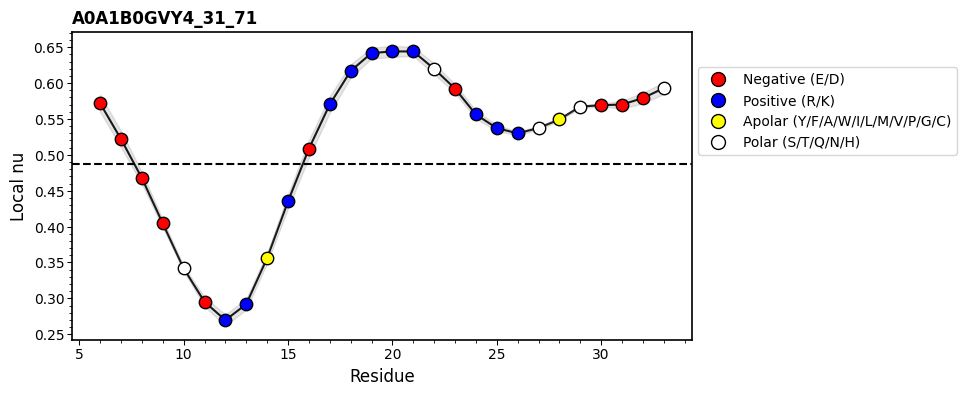

In [29]:
subchain_nu_plot(subchain_random_1,8,4)

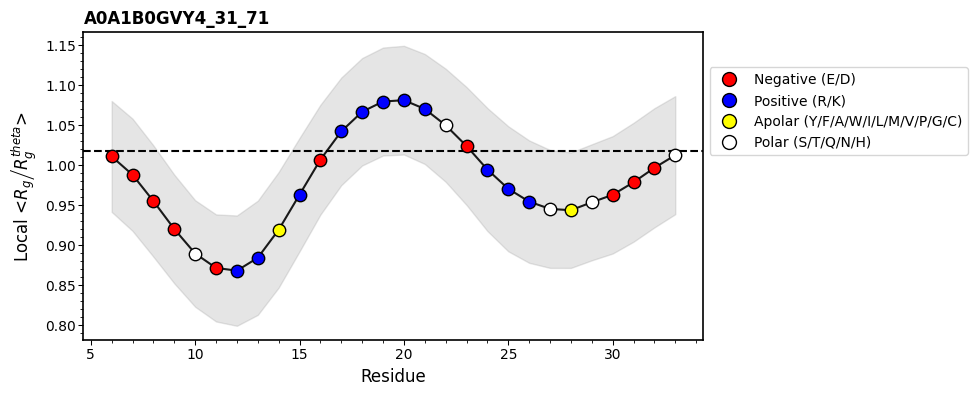

In [32]:
subchain_Rg_Rg_theta_mean_plot(subchain_random_1,8,4)

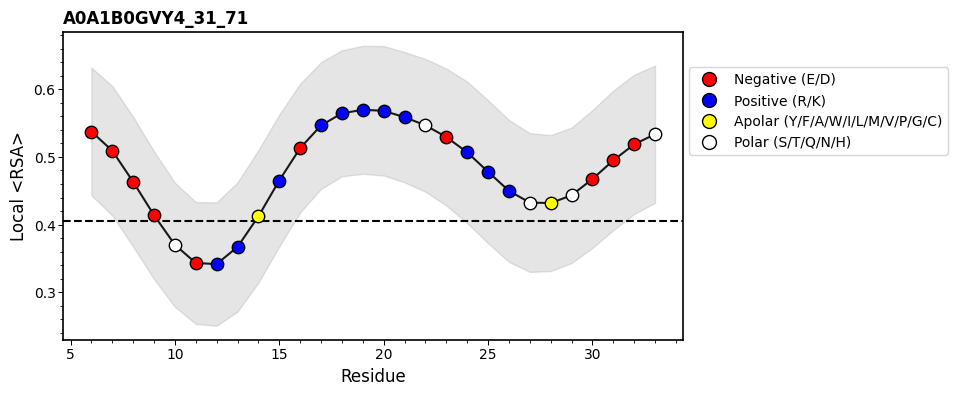

In [117]:
subchain_RSA_plot(subchain_random_1,8,4)

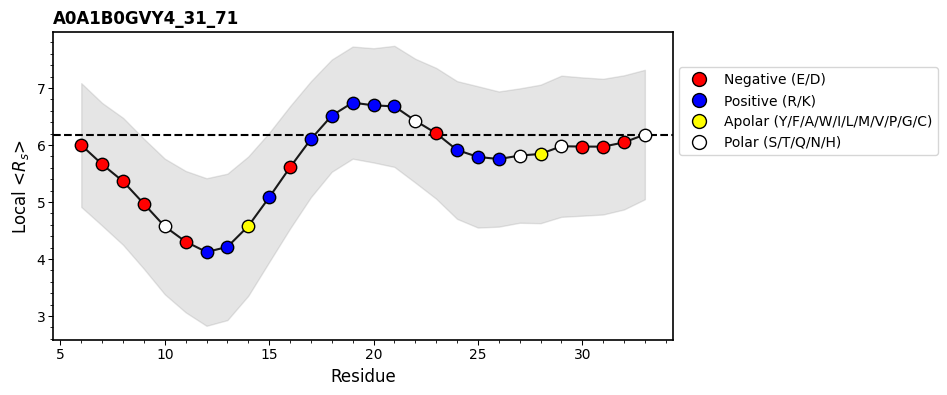

In [118]:
subchain_Rs_plot(subchain_random_1,8,4)

In [33]:
del subchain_random_1

In [34]:
subchain_random_2 = compute_30mer_data_from_seq_name_no_hdf5('Q9Y5B9_917_1047',3)

residue 0 to 29 done
residue 1 to 30 done
residue 2 to 31 done
residue 3 to 32 done
residue 4 to 33 done
residue 5 to 34 done
residue 6 to 35 done
residue 7 to 36 done
residue 8 to 37 done
residue 9 to 38 done
residue 10 to 39 done
residue 11 to 40 done
residue 12 to 41 done
residue 13 to 42 done
residue 14 to 43 done
residue 15 to 44 done
residue 16 to 45 done
residue 17 to 46 done
residue 18 to 47 done
residue 19 to 48 done
residue 20 to 49 done
residue 21 to 50 done
residue 22 to 51 done
residue 23 to 52 done
residue 24 to 53 done
residue 25 to 54 done
residue 26 to 55 done
residue 27 to 56 done
residue 28 to 57 done
residue 29 to 58 done
residue 30 to 59 done
residue 31 to 60 done
residue 32 to 61 done
residue 33 to 62 done
residue 34 to 63 done
residue 35 to 64 done
residue 36 to 65 done
residue 37 to 66 done
residue 38 to 67 done
residue 39 to 68 done
residue 40 to 69 done
residue 41 to 70 done
residue 42 to 71 done
residue 43 to 72 done
residue 44 to 73 done
residue 45 to 74 don

In [35]:
subchain_random_2['mid_residue'] = (subchain_random_2['start_res_zeroindex'] + subchain_random_2['end_res_zeroindex']) // 2


In [74]:
subchain_stats_rsa = subchain_random_2.groupby('mid_residue').agg({
        'RSA': ['mean', 'std']}).reset_index()
subchain_random_2_SM_RSA = (subchain_stats_rsa['RSA']['mean'].max() - subchain_stats_rsa['RSA']['mean'].min())/(subchain_stats_rsa['RSA']['std'].mean())
subchain_stats_rs = subchain_random_2.groupby('mid_residue').agg({
        'inst_ratio': ['mean', 'std']}).reset_index()
subchain_random_2_SM_Rs = (subchain_stats_rs['inst_ratio']['mean'].max() - subchain_stats_rs['inst_ratio']['mean'].min())/(subchain_stats_rs['inst_ratio']['std'].mean())
subchain_random_2_SM_RSA

0.9662671496766178

In [76]:
subchain_random_2_SM_Rs

1.2576419493496818

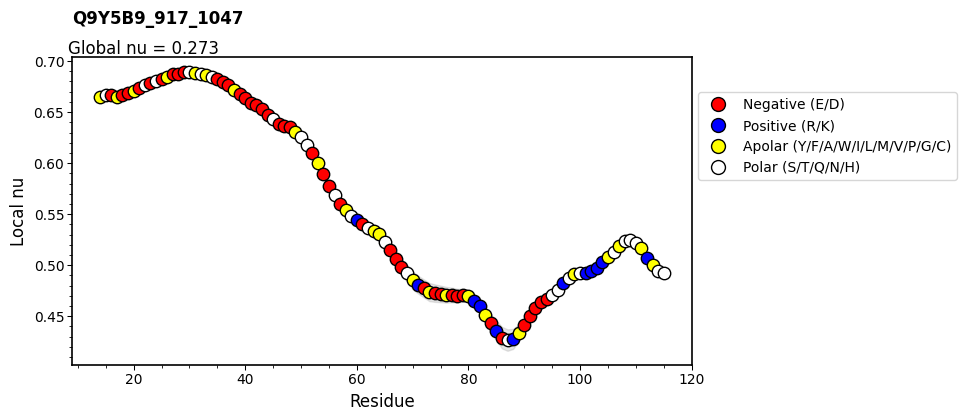

In [35]:
subchain_nu_plot(subchain_random_2,8,4)

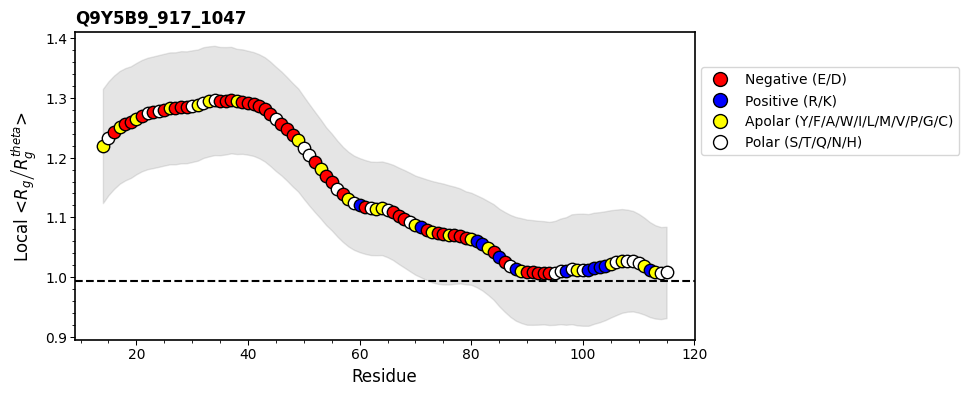

In [36]:
subchain_Rg_Rg_theta_mean_plot(subchain_random_2,8,4)

In [47]:
subchain_random_2.reset_index()[]

,index,fasta_sequence,start_res_zeroindex,end_res_zeroindex,full_protein_fasta,full_protein_rgyr,full_protein_nu_recompute,full_protein_nu_recompute_err,full_protein_ratio,full_protein_RSA,...,seq_name,Rg/nm,nu_recompute,nu_recompute_err,ete,inst_ratio,RSA,AFRC_mean_rg_theta,rg_rg_theta_mean,mid_residue
0,0,FEQGGWSFLEPEGEGSDAEEGDSESEIEDE,0,29,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,...,Q9Y5B9_917_1047,1.594158,0.664445,0.004062,4.432764,7.731904,0.312348,13.595199,1.172589,14
1,1,FEQGGWSFLEPEGEGSDAEEGDSESEIEDE,0,29,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,...,Q9Y5B9_917_1047,1.492756,0.664445,0.004062,3.277004,4.819214,0.654662,13.595199,1.098002,14
2,2,FEQGGWSFLEPEGEGSDAEEGDSESEIEDE,0,29,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,...,Q9Y5B9_917_1047,1.453494,0.664445,0.004062,3.139166,4.664468,0.396826,13.595199,1.069123,14
3,3,FEQGGWSFLEPEGEGSDAEEGDSESEIEDE,0,29,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,...,Q9Y5B9_917_1047,1.874051,0.664445,0.004062,5.369860,8.210379,0.741988,13.595199,1.378465,14
4,4,FEQGGWSFLEPEGEGSDAEEGDSESEIEDE,0,29,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,...,Q9Y5B9_917_1047,1.502310,0.664445,0.004062,4.536436,9.118227,0.718061,13.595199,1.105030,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101995,995,RKRKASVHSSGRGSNRGSRHSSAPPKKKRK,101,130,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,...,Q9Y5B9_917_1047,1.210583,0.492392,0.007615,2.095227,2.995524,0.296595,13.719504,0.882381,115
101996,996,RKRKASVHSSGRGSNRGSRHSSAPPKKKRK,101,130,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,...,Q9Y5B9_917_1047,1.336005,0.492392,0.007615,3.890332,8.479240,0.359650,13.719504,0.973800,115
101997,997,RKRKASVHSSGRGSNRGSRHSSAPPKKKRK,101,130,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,...,Q9Y5B9_917_1047,1.323323,0.492392,0.007615,2.076847,2.463072,0.267160,13.719504,0.964556,115
101998,998,RKRKASVHSSGRGSNRGSRHSSAPPKKKRK,101,130,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,...,Q9Y5B9_917_1047,1.173640,0.492392,0.007615,3.849859,10.760181,0.192481,13.719504,0.855454,115


In [55]:
subchain_random_2[((subchain_random_2.inst_ratio>11.5) & (subchain_random_2.mid_residue==20))].index.intersection(subchain_random_2[((subchain_random_2.inst_ratio<3) & (subchain_random_2.mid_residue==95))].index.values)  



Index([140, 453], dtype='int64')

In [62]:
subchain_random_2

,fasta_sequence,start_res_zeroindex,end_res_zeroindex,full_protein_fasta,full_protein_rgyr,full_protein_nu_recompute,full_protein_nu_recompute_err,full_protein_ratio,full_protein_RSA,full_protein_rg_rg_theta_mean,seq_name,Rg/nm,nu_recompute,nu_recompute_err,ete,inst_ratio,RSA,AFRC_mean_rg_theta,rg_rg_theta_mean,mid_residue
0,FEQGGWSFLEPEGEGSDAEEGDSESEIEDE,0,29,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,0.993248,Q9Y5B9_917_1047,1.594158,0.664445,0.004062,4.432764,7.731904,0.312348,13.595199,1.172589,14
1,FEQGGWSFLEPEGEGSDAEEGDSESEIEDE,0,29,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,0.993248,Q9Y5B9_917_1047,1.492756,0.664445,0.004062,3.277004,4.819214,0.654662,13.595199,1.098002,14
2,FEQGGWSFLEPEGEGSDAEEGDSESEIEDE,0,29,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,0.993248,Q9Y5B9_917_1047,1.453494,0.664445,0.004062,3.139166,4.664468,0.396826,13.595199,1.069123,14
3,FEQGGWSFLEPEGEGSDAEEGDSESEIEDE,0,29,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,0.993248,Q9Y5B9_917_1047,1.874051,0.664445,0.004062,5.369860,8.210379,0.741988,13.595199,1.378465,14
4,FEQGGWSFLEPEGEGSDAEEGDSESEIEDE,0,29,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,0.993248,Q9Y5B9_917_1047,1.502310,0.664445,0.004062,4.536436,9.118227,0.718061,13.595199,1.105030,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,RKRKASVHSSGRGSNRGSRHSSAPPKKKRK,101,130,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,0.993248,Q9Y5B9_917_1047,1.210583,0.492392,0.007615,2.095227,2.995524,0.296595,13.719504,0.882381,115
996,RKRKASVHSSGRGSNRGSRHSSAPPKKKRK,101,130,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,0.993248,Q9Y5B9_917_1047,1.336005,0.492392,0.007615,3.890332,8.479240,0.359650,13.719504,0.973800,115
997,RKRKASVHSSGRGSNRGSRHSSAPPKKKRK,101,130,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,0.993248,Q9Y5B9_917_1047,1.323323,0.492392,0.007615,2.076847,2.463072,0.267160,13.719504,0.964556,115
998,RKRKASVHSSGRGSNRGSRHSSAPPKKKRK,101,130,FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...,2.841769,0.273108,0.010545,4.077155,0.365211,0.993248,Q9Y5B9_917_1047,1.173640,0.492392,0.007615,3.849859,10.760181,0.192481,13.719504,0.855454,115


In [61]:
subchain_random_2[subchain_random_2.mid_residue==95].loc[140]

fasta_sequence                                      RKADRESRYEEEEEQSRSMSRKRKASVHSS
start_res_zeroindex                                                             81
end_res_zeroindex                                                              110
full_protein_fasta               FEQGGWSFLEPEGEGSDAEEGDSESEIEDETFNPSEDDYEEEEEDS...
full_protein_rgyr                                                         2.841769
full_protein_nu_recompute                                                 0.273108
full_protein_nu_recompute_err                                             0.010545
full_protein_ratio                                                        4.077155
full_protein_RSA                                                          0.365211
full_protein_rg_rg_theta_mean                                             0.993248
seq_name                                                           Q9Y5B9_917_1047
Rg/nm                                                                      1.16443
nu_r

In [59]:
999+10

1009

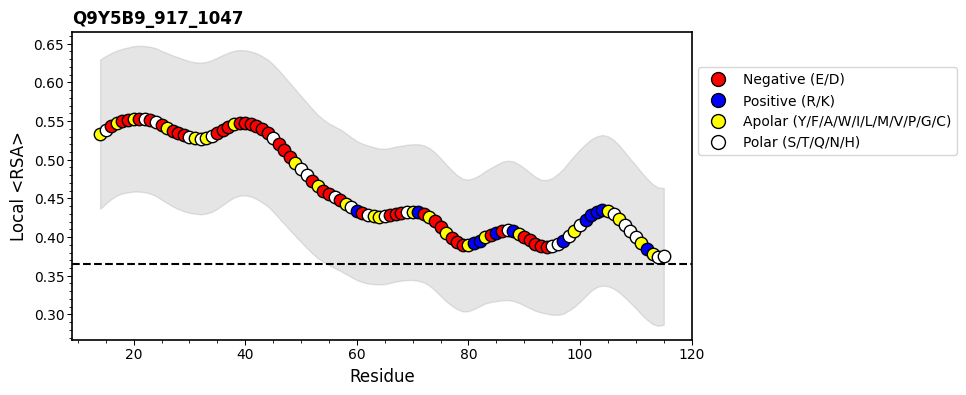

In [134]:
subchain_RSA_plot(subchain_random_2,8,4)

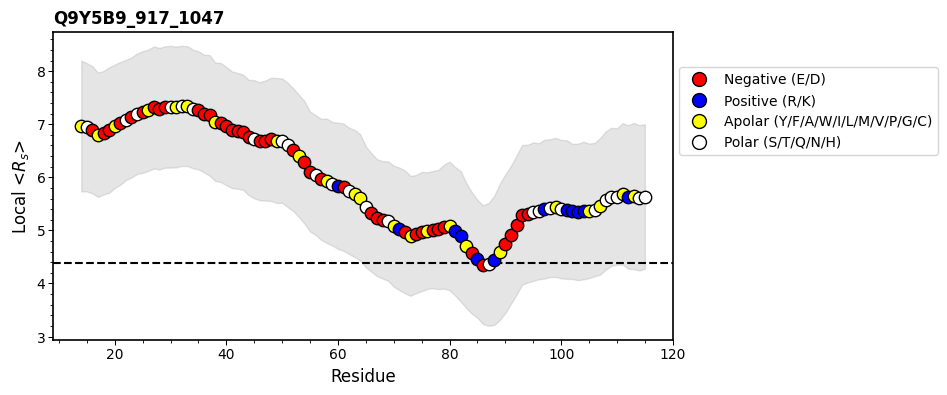

In [135]:
subchain_Rs_plot(subchain_random_2,8,4)

In [77]:
del subchain_random_2

In [66]:
idrome_prop_flucs[(idrome_prop_flucs.N==131) & (idrome_prop_flucs.nu>0.5)]

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,mid_res_max_mean_rg_rg_theta,stdev_mean_rg_rg_theta,min_mean_nu,mid_res_min_mean_nu,max_mean_nu,mid_res_max_mean_nu,stdev_mean_nu,glob_loc_fac_RSA,glob_loc_fac_Rs,glob_loc_fac_rg_theta_mean
23,A0A0A6YYL3_331_461,A0A0A6YYL3,131,0.567,10.204387,6.387528,0.981006,0.217707,3.585452,8.660681,...,40.0,0.045213,0.534556,95.0,0.638094,34.0,0.028316,0.301987,0.281921,1.629749
189,A0JP26_1_131,A0JP26,131,0.509,10.027504,6.031929,0.944303,0.223624,3.123868,7.205940,...,23.0,0.035333,0.495433,111.0,0.603411,24.0,0.025126,0.106606,0.180180,0.842297
1250,H0YL09_1_131,H0YL09,131,0.509,10.080842,6.019604,0.844706,0.206000,3.194334,7.418531,...,96.0,0.017646,0.542168,108.0,0.587308,90.0,0.011950,-0.469972,-0.263057,1.181216
1467,O00507_2425_2555,O00507,131,0.555,10.167636,6.229070,1.003685,0.239772,3.554636,8.506893,...,61.0,0.049303,0.555337,19.0,0.646612,65.0,0.021881,0.189011,-0.006302,1.095231
2098,O15535_126_256,O15535,131,0.547,10.195607,6.220213,0.897627,0.214877,3.556901,8.481538,...,74.0,0.010041,0.560216,114.0,0.620988,52.0,0.012863,-1.010255,-0.058731,3.258690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27025,Q9UQB8_248_378,Q9UQB8,131,0.522,10.061996,6.186367,0.877435,0.198773,3.271309,7.727758,...,104.0,0.014360,0.562203,68.0,0.607150,108.0,0.012773,-0.951157,-0.329926,1.675290
27047,Q9UQQ2_73_203,Q9UQQ2,131,0.530,9.996541,6.050174,0.915244,0.213471,3.244811,7.592024,...,67.0,0.015672,0.540940,82.0,0.607216,34.0,0.018629,-0.185948,-0.006043,1.885634
27330,Q9Y336_333_463,Q9Y336,131,0.522,10.093235,6.025726,0.929288,0.216604,3.220747,7.501551,...,82.0,0.026504,0.530671,55.0,0.609050,85.0,0.019911,-0.056748,0.181314,1.297087
27590,Q9Y4L1_564_694,Q9Y4L1,131,0.507,10.291888,5.396163,0.931871,0.220322,3.698302,8.072088,...,47.0,0.059728,0.537919,115.0,0.696314,48.0,0.041434,0.218623,-0.507041,1.265804


In [63]:
subchain_random_3 = compute_30mer_data_from_seq_name_no_hdf5('A0A087WVF3_1_53',3)

residue 0 to 17 done
residue 1 to 18 done
residue 2 to 19 done
residue 3 to 20 done
residue 4 to 21 done
residue 5 to 22 done
residue 6 to 23 done
residue 7 to 24 done
residue 8 to 25 done
residue 9 to 26 done
residue 10 to 27 done
residue 11 to 28 done
residue 12 to 29 done
residue 13 to 30 done
residue 14 to 31 done
residue 15 to 32 done
residue 16 to 33 done
residue 17 to 34 done
residue 18 to 35 done
residue 19 to 36 done
residue 20 to 37 done
residue 21 to 38 done
residue 22 to 39 done
residue 23 to 40 done
residue 24 to 41 done
residue 25 to 42 done
residue 26 to 43 done
residue 27 to 44 done
residue 28 to 45 done
residue 29 to 46 done
residue 30 to 47 done
residue 31 to 48 done
residue 32 to 49 done
residue 33 to 50 done
residue 34 to 51 done
residue 35 to 52 done
ALL DONE


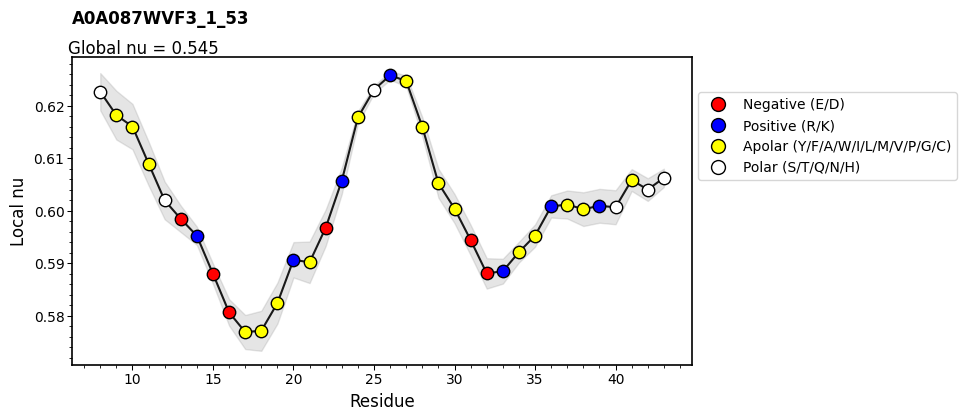

In [40]:
subchain_nu_plot(subchain_random_3,8,4)

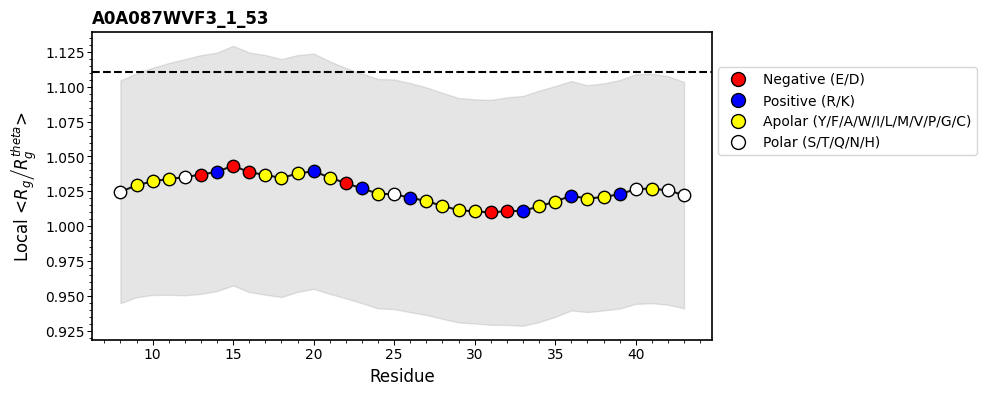

In [41]:
subchain_Rg_Rg_theta_mean_plot(subchain_random_3,8,4)

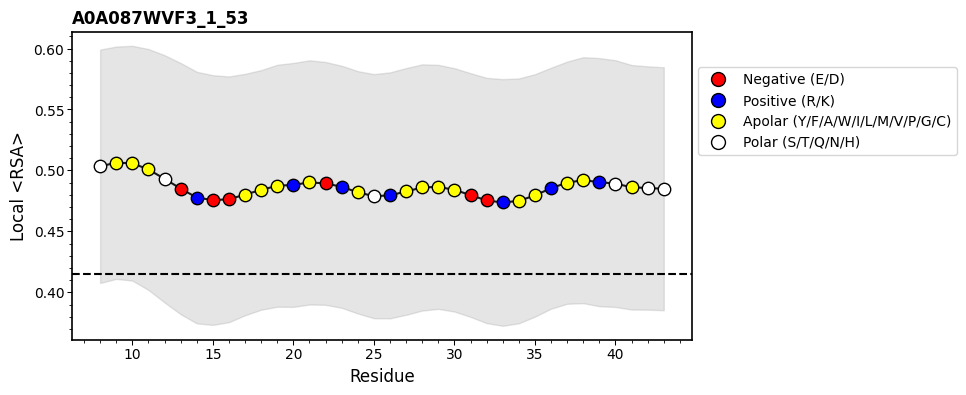

In [139]:
subchain_RSA_plot(subchain_random_3,8,4)

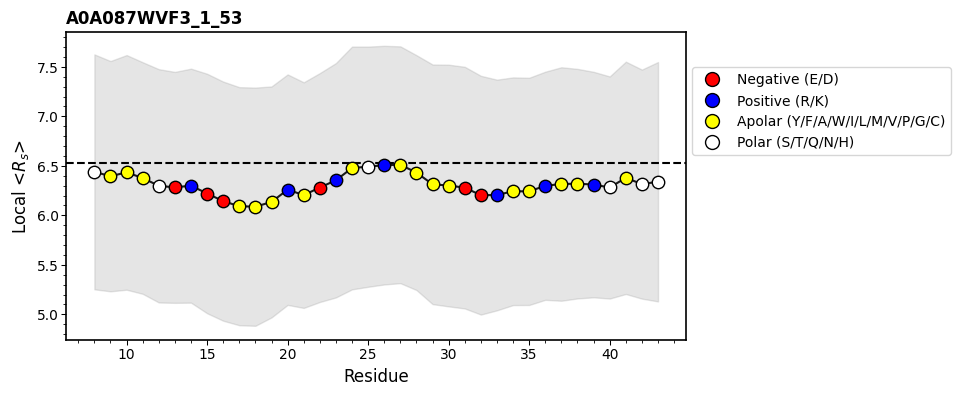

In [140]:
subchain_Rs_plot(subchain_random_3,8,4)

In [42]:
del subchain_random_3

In [107]:
idrome_prop_flucs[idrome_prop_flucs.seq_name=='W6CW81_1_113'].stdev_mean_RSA

28056    0.00948
Name: stdev_mean_RSA, dtype: float64

In [78]:
subchain_random_4 = compute_30mer_data_from_seq_name_no_hdf5('W6CW81_1_113',3)

residue 0 to 29 done
residue 1 to 30 done
residue 2 to 31 done
residue 3 to 32 done
residue 4 to 33 done
residue 5 to 34 done
residue 6 to 35 done
residue 7 to 36 done
residue 8 to 37 done
residue 9 to 38 done
residue 10 to 39 done
residue 11 to 40 done
residue 12 to 41 done
residue 13 to 42 done
residue 14 to 43 done
residue 15 to 44 done
residue 16 to 45 done
residue 17 to 46 done
residue 18 to 47 done
residue 19 to 48 done
residue 20 to 49 done
residue 21 to 50 done
residue 22 to 51 done
residue 23 to 52 done
residue 24 to 53 done
residue 25 to 54 done
residue 26 to 55 done
residue 27 to 56 done
residue 28 to 57 done
residue 29 to 58 done
residue 30 to 59 done
residue 31 to 60 done
residue 32 to 61 done
residue 33 to 62 done
residue 34 to 63 done
residue 35 to 64 done
residue 36 to 65 done
residue 37 to 66 done
residue 38 to 67 done
residue 39 to 68 done
residue 40 to 69 done
residue 41 to 70 done
residue 42 to 71 done
residue 43 to 72 done
residue 44 to 73 done
residue 45 to 74 don

In [82]:
subchain_random_4['mid_residue'] = (subchain_random_4['start_res_zeroindex'] + subchain_random_4['end_res_zeroindex']) // 2
subchain_stats_rsa = subchain_random_4.groupby('mid_residue').agg({
        'RSA': ['mean', 'std']}).reset_index()
subchain_random_4_SM_RSA = (subchain_stats_rsa['RSA']['mean'].max() - subchain_stats_rsa['RSA']['mean'].min())/(subchain_stats_rsa['RSA']['std'].mean())
subchain_stats_rs = subchain_random_4.groupby('mid_residue').agg({
        'inst_ratio': ['mean', 'std']}).reset_index()
subchain_random_4_SM_Rs = (subchain_stats_rs['inst_ratio']['mean'].max() - subchain_stats_rs['inst_ratio']['mean'].min())/(subchain_stats_rs['inst_ratio']['std'].mean())
subchain_random_4_SM_RSA

0.18355151392638647

In [83]:
subchain_random_4_SM_Rs

0.14681428274049163

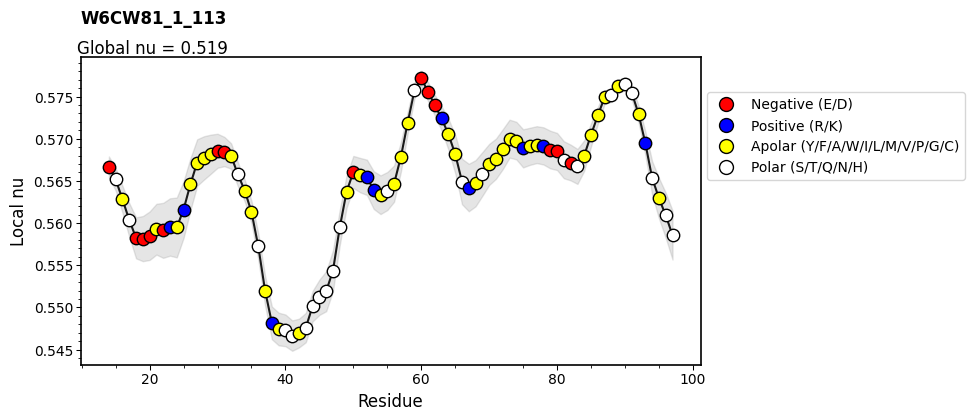

In [44]:
subchain_nu_plot(subchain_random_4,8,4)

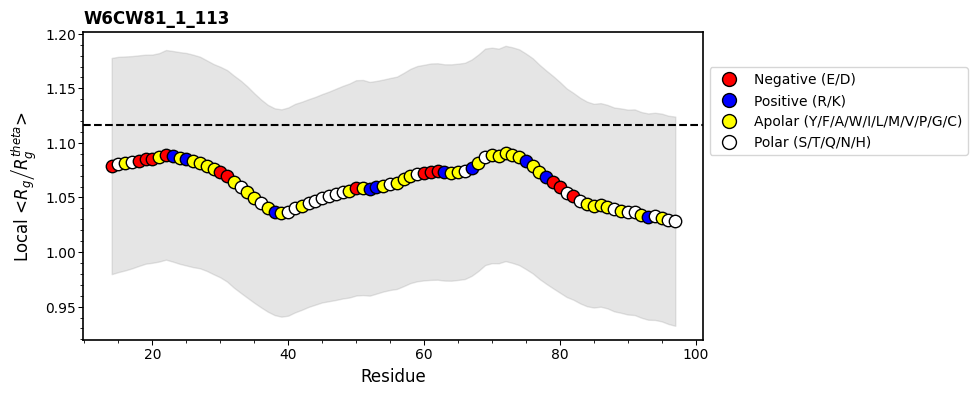

In [45]:
subchain_Rg_Rg_theta_mean_plot(subchain_random_4,8,4)

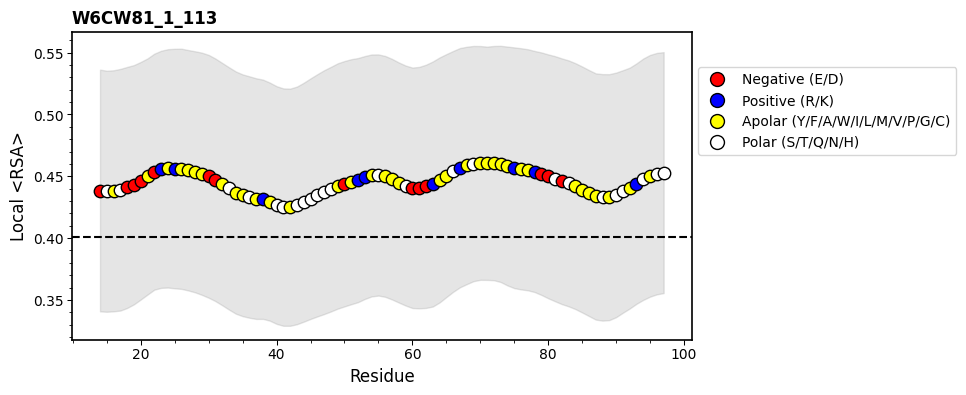

In [142]:
subchain_RSA_plot(subchain_random_4,8,4)

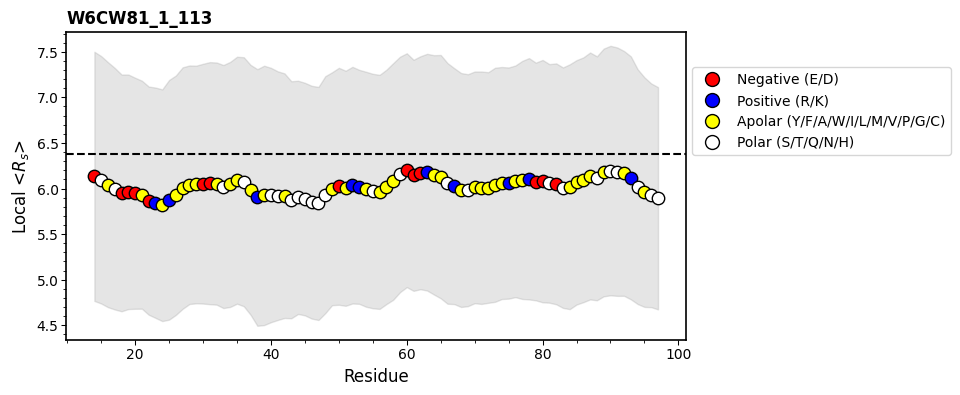

In [143]:
subchain_Rs_plot(subchain_random_4,8,4)

In [84]:
del subchain_random_4

In [93]:
idrome_prop_flucs[(idrome_prop_flucs.stdev_mean_RSA>0.04) & (idrome_prop_flucs.N==131)]

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,mid_res_max_mean_rg_rg_theta,stdev_mean_rg_rg_theta,min_mean_nu,mid_res_min_mean_nu,max_mean_nu,mid_res_max_mean_nu,stdev_mean_nu,glob_loc_fac_RSA,glob_loc_fac_Rs,glob_loc_fac_rg_theta_mean
12132,Q5SSJ5_423_553,Q5SSJ5,131,0.408,10.109788,5.768771,0.855473,0.195957,2.924291,6.641244,...,14.0,0.089354,0.224921,29.0,0.656002,98.0,0.128652,0.226746,0.532513,0.386443
19787,Q969G5_131_261,Q969G5,131,0.520,10.074117,6.642079,0.816867,0.190390,3.106566,7.634488,...,25.0,0.066104,0.350035,43.0,0.648182,115.0,0.078813,0.345443,0.788797,0.679369
24120,Q9HCK8_1662_1792,Q9HCK8,131,0.375,10.088851,5.438045,0.658307,0.176027,2.771712,6.033621,...,52.0,0.074783,0.318348,74.0,0.625031,37.0,0.092249,-0.039994,0.449903,0.157356
25761,Q9UBF8_1_131,Q9UBF8,131,0.516,10.044311,5.909786,0.918367,0.234161,3.260681,7.528576,...,89.0,0.062483,0.342386,106.0,0.618509,64.0,0.080765,0.717969,0.527372,1.090016
27659,Q9Y5B9_917_1047,Q9Y5B9,131,0.273,10.187119,4.268372,0.726670,0.181412,2.836427,5.510589,...,37.0,0.111037,0.426632,87.0,0.689299,29.0,0.089736,-0.053203,-0.092879,-0.053606


In [85]:
subchain_random_5 = compute_30mer_data_from_seq_name_no_hdf5('Q9HCK8_1662_1792',3)
subchain_random_5['mid_residue'] = (subchain_random_5['start_res_zeroindex'] + subchain_random_5['end_res_zeroindex']) // 2

residue 0 to 29 done
residue 1 to 30 done
residue 2 to 31 done
residue 3 to 32 done
residue 4 to 33 done
residue 5 to 34 done
residue 6 to 35 done
residue 7 to 36 done
residue 8 to 37 done
residue 9 to 38 done
residue 10 to 39 done
residue 11 to 40 done
residue 12 to 41 done
residue 13 to 42 done
residue 14 to 43 done
residue 15 to 44 done
residue 16 to 45 done
residue 17 to 46 done
residue 18 to 47 done
residue 19 to 48 done
residue 20 to 49 done
residue 21 to 50 done
residue 22 to 51 done
residue 23 to 52 done
residue 24 to 53 done
residue 25 to 54 done
residue 26 to 55 done
residue 27 to 56 done
residue 28 to 57 done
residue 29 to 58 done
residue 30 to 59 done
residue 31 to 60 done
residue 32 to 61 done
residue 33 to 62 done
residue 34 to 63 done
residue 35 to 64 done
residue 36 to 65 done
residue 37 to 66 done
residue 38 to 67 done
residue 39 to 68 done
residue 40 to 69 done
residue 41 to 70 done
residue 42 to 71 done
residue 43 to 72 done
residue 44 to 73 done
residue 45 to 74 don

In [86]:
subchain_stats_rsa = subchain_random_5.groupby('mid_residue').agg({
        'RSA': ['mean', 'std']}).reset_index()
subchain_random_5_SM_RSA = (subchain_stats_rsa['RSA']['mean'].max() - subchain_stats_rsa['RSA']['mean'].min())/(subchain_stats_rsa['RSA']['std'].mean())
subchain_stats_rs = subchain_random_5.groupby('mid_residue').agg({
        'inst_ratio': ['mean', 'std']}).reset_index()
subchain_random_5_SM_Rs = (subchain_stats_rs['inst_ratio']['mean'].max() - subchain_stats_rs['inst_ratio']['mean'].min())/(subchain_stats_rs['inst_ratio']['std'].mean())
subchain_random_5_SM_RSA

0.8994239395318095

In [87]:
subchain_random_5_SM_Rs

1.2497914923194458

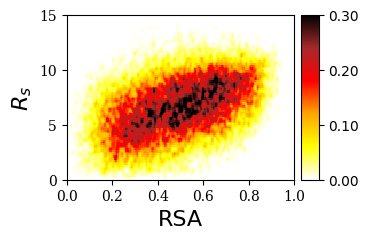

In [31]:
# Define the x and y data 
# For example just using random numbers
#ORDER is RW->RW->salmon
#ONLY epas=0 data here
x_variable='RSA'
y_variable="$R_s$"

test_df = subchain_random_5[subchain_random_5.mid_residue<=40].copy()
x = test_df['RSA']
y = test_df['inst_ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,15]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(4.5,3))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 200
nybins = 100
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
H = gaussian_filter(H,sigma=1)    
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])    
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,vmin=0,vmax=0.3,
       interpolation='nearest', origin='lower',aspect=aspectratio))
#axTemperature.text(0.7, 0.1, f'$\\nu$ ~ {format(test_df.nu.mean(),"0.2f")}', color='black', verticalalignment='top', horizontalalignment='left',
#                   fontsize=9,
#        transform=axTemperature.get_xaxis_transform())

 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=16)
axTemperature.set_ylabel(ylabel,fontsize=16)
 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(10)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(10)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 

def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.68)
cbar_ax = fig.add_axes([left+width-0.008, bottom, 0.04, height])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))

#Show the plot
plt.draw()
del test_df
#plt.savefig('figures_for_paper/Entire_IDRome_nu_sorted_Rs_RSA_heatmap_first_300_seq.png',format='png',
#           dpi=1000,bbox_inches='tight')

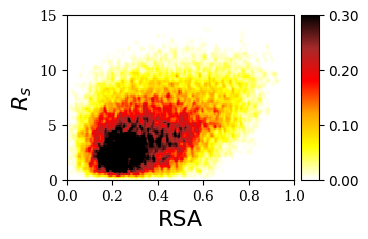

In [32]:
# Define the x and y data 
# For example just using random numbers
#ORDER is RW->RW->salmon
#ONLY epas=0 data here
x_variable='RSA'
y_variable="$R_s$"

test_df = subchain_random_5[(subchain_random_5.mid_residue>=60) & (subchain_random_5.mid_residue<=85)].copy()
x = test_df['RSA']
y = test_df['inst_ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,15]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(4.5,3))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 200
nybins = 100
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
H = gaussian_filter(H,sigma=1)    
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])    
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,vmin=0,vmax=0.3,
       interpolation='nearest', origin='lower',aspect=aspectratio))
#axTemperature.text(0.7, 0.1, f'$\\nu$ ~ {format(test_df.nu.mean(),"0.2f")}', color='black', verticalalignment='top', horizontalalignment='left',
#                   fontsize=9,
#        transform=axTemperature.get_xaxis_transform())

 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=16)
axTemperature.set_ylabel(ylabel,fontsize=16)
 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(10)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(10)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 

def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.68)
cbar_ax = fig.add_axes([left+width-0.008, bottom, 0.04, height])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))

#Show the plot
plt.draw()
del test_df
#plt.savefig('figures_for_paper/Entire_IDRome_nu_sorted_Rs_RSA_heatmap_first_300_seq.png',format='png',
#           dpi=1000,bbox_inches='tight')

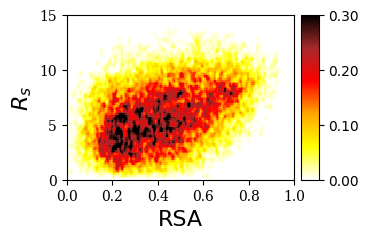

In [30]:
# Define the x and y data 
# For example just using random numbers
#ORDER is RW->RW->salmon
#ONLY epas=0 data here
x_variable='RSA'
y_variable="$R_s$"

test_df = subchain_random_5[ (subchain_random_5.mid_residue>=100)].copy()
x = test_df['RSA']
y = test_df['inst_ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,15]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(4.5,3))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 200
nybins = 100
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
H = gaussian_filter(H,sigma=1)    
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])    
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,vmin=0,vmax=0.3,
       interpolation='nearest', origin='lower',aspect=aspectratio))
#axTemperature.text(0.7, 0.1, f'$\\nu$ ~ {format(test_df.nu.mean(),"0.2f")}', color='black', verticalalignment='top', horizontalalignment='left',
#                   fontsize=9,
#        transform=axTemperature.get_xaxis_transform())

 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=16)
axTemperature.set_ylabel(ylabel,fontsize=16)
 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(10)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(10)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 

def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.68)
cbar_ax = fig.add_axes([left+width-0.008, bottom, 0.04, height])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))

#Show the plot
plt.draw()
del test_df
#plt.savefig('figures_for_paper/Entire_IDRome_nu_sorted_Rs_RSA_heatmap_first_300_seq.png',format='png',
#           dpi=1000,bbox_inches='tight')

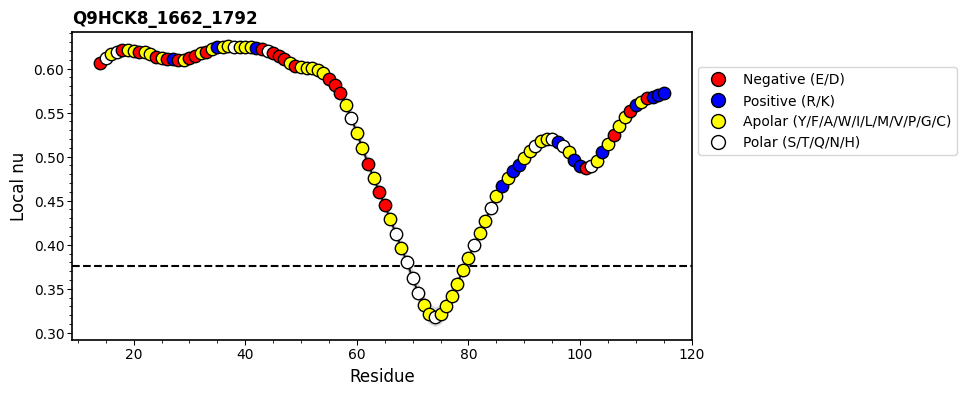

In [101]:
subchain_nu_plot(subchain_random_5,8,4)

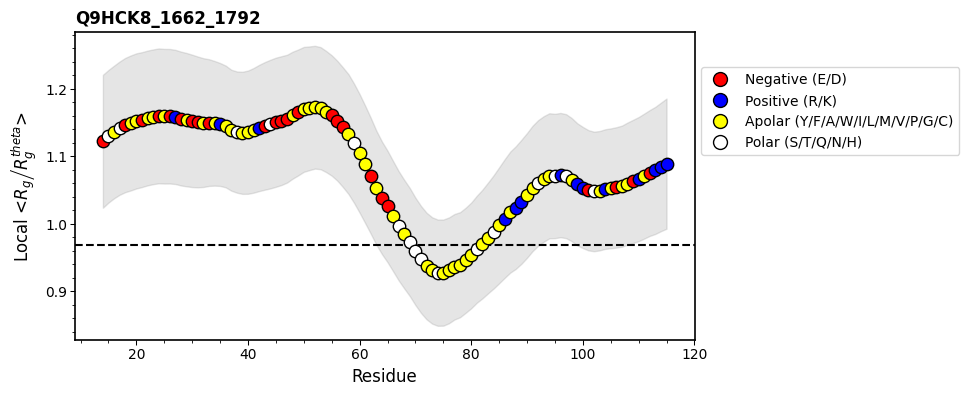

In [102]:
subchain_Rg_Rg_theta_mean_plot(subchain_random_5,8,4)

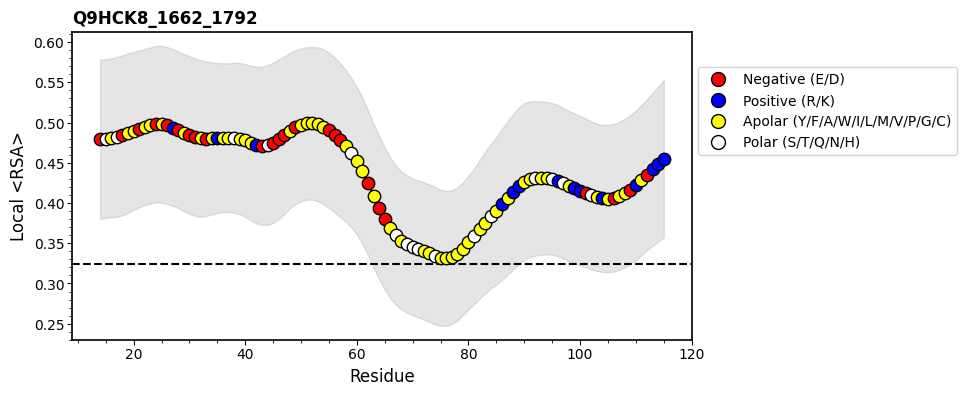

In [103]:
subchain_RSA_plot(subchain_random_5,8,4)

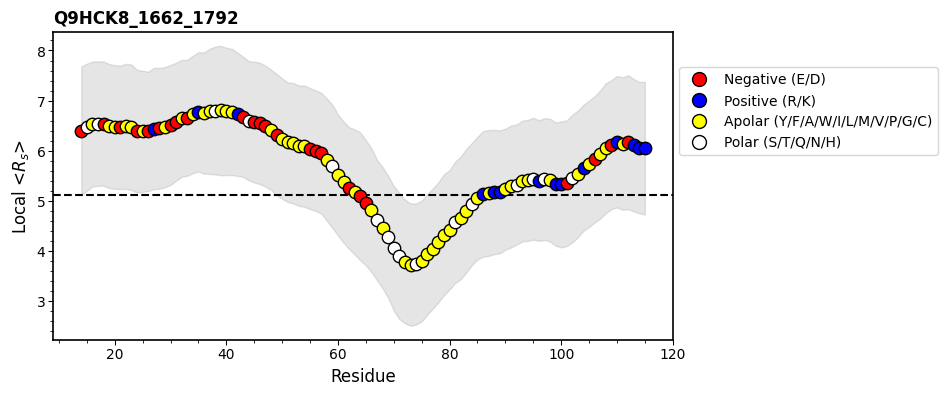

In [104]:
subchain_Rs_plot(subchain_random_5,8,4)

In [88]:
del subchain_random_5

In [89]:
#subchain_random_5 = compute_30mer_data_from_seq_name_no_hdf5('Q15672_1_101',3)
subchain_random_5 = compute_30mer_data_from_seq_name_no_hdf5('Q9UIF8_1259_1347',3)

residue 0 to 29 done
residue 1 to 30 done
residue 2 to 31 done
residue 3 to 32 done
residue 4 to 33 done
residue 5 to 34 done
residue 6 to 35 done
residue 7 to 36 done
residue 8 to 37 done
residue 9 to 38 done
residue 10 to 39 done
residue 11 to 40 done
residue 12 to 41 done
residue 13 to 42 done
residue 14 to 43 done
residue 15 to 44 done
residue 16 to 45 done
residue 17 to 46 done
residue 18 to 47 done
residue 19 to 48 done
residue 20 to 49 done
residue 21 to 50 done
residue 22 to 51 done
residue 23 to 52 done
residue 24 to 53 done
residue 25 to 54 done
residue 26 to 55 done
residue 27 to 56 done
residue 28 to 57 done
residue 29 to 58 done
residue 30 to 59 done
residue 31 to 60 done
residue 32 to 61 done
residue 33 to 62 done
residue 34 to 63 done
residue 35 to 64 done
residue 36 to 65 done
residue 37 to 66 done
residue 38 to 67 done
residue 39 to 68 done
residue 40 to 69 done
residue 41 to 70 done
residue 42 to 71 done
residue 43 to 72 done
residue 44 to 73 done
residue 45 to 74 don

In [90]:
subchain_random_5['mid_residue'] = (subchain_random_5['start_res_zeroindex'] + subchain_random_5['end_res_zeroindex']) // 2
subchain_stats_rsa = subchain_random_5.groupby('mid_residue').agg({
        'RSA': ['mean', 'std']}).reset_index()
subchain_random_5_SM_RSA = (subchain_stats_rsa['RSA']['mean'].max() - subchain_stats_rsa['RSA']['mean'].min())/(subchain_stats_rsa['RSA']['std'].mean())
subchain_stats_rs = subchain_random_5.groupby('mid_residue').agg({
        'inst_ratio': ['mean', 'std']}).reset_index()
subchain_random_5_SM_Rs = (subchain_stats_rs['inst_ratio']['mean'].max() - subchain_stats_rs['inst_ratio']['mean'].min())/(subchain_stats_rs['inst_ratio']['std'].mean())
subchain_random_5_SM_RSA

1.3958125198168345

In [91]:
subchain_random_5_SM_Rs

1.4594950675540115

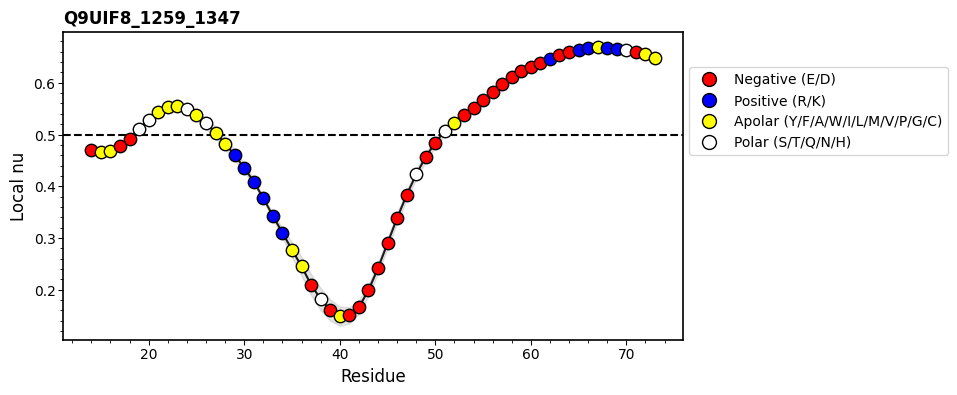

In [106]:
subchain_nu_plot(subchain_random_5,8,4)

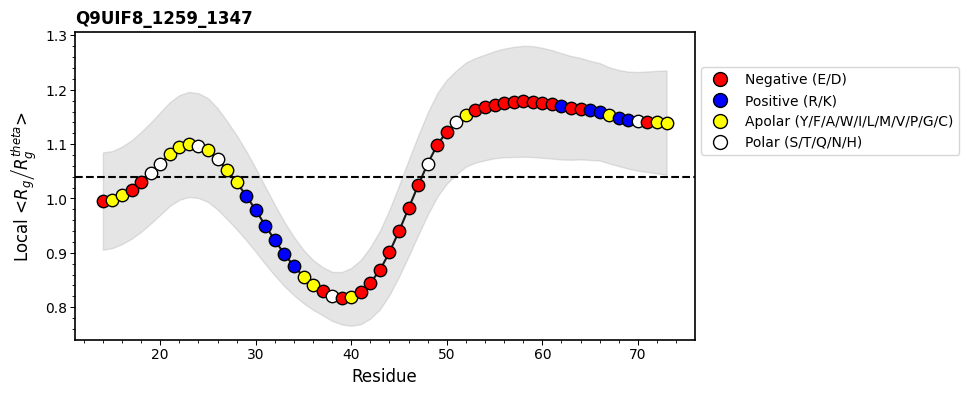

In [107]:
subchain_Rg_Rg_theta_mean_plot(subchain_random_5,8,4)

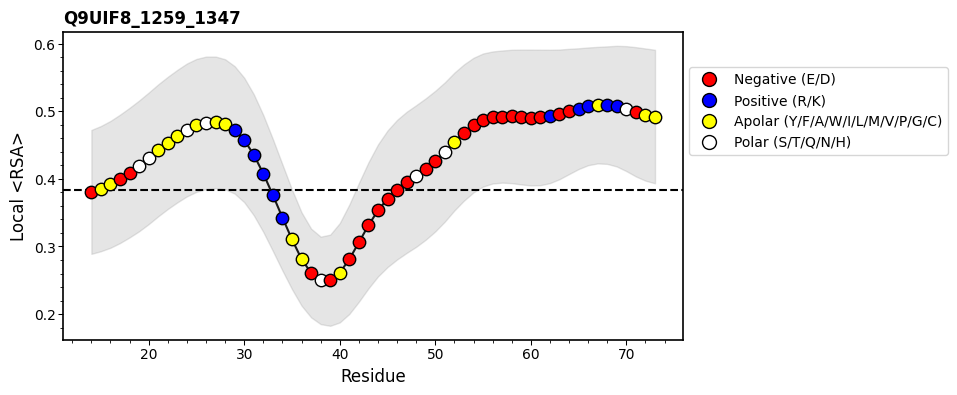

In [108]:
subchain_RSA_plot(subchain_random_5,8,4)

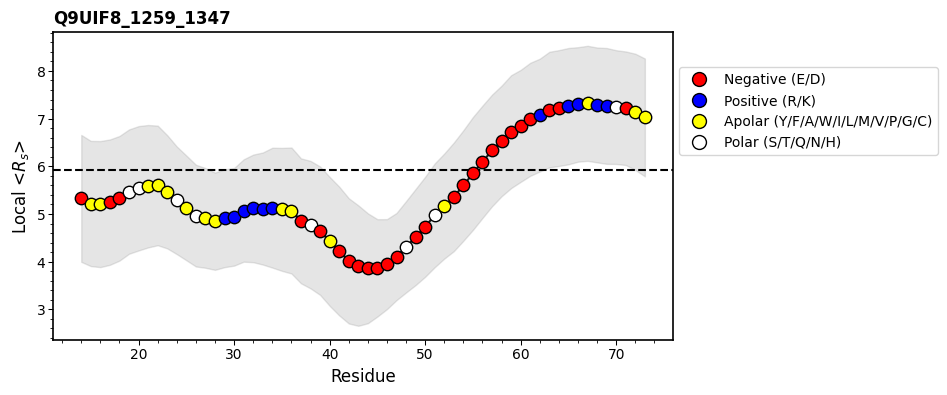

In [109]:
subchain_Rs_plot(subchain_random_5,8,4)

In [92]:
del subchain_random_5

In [63]:
idrome_prop_flucs[(idrome_prop_flucs['stdev_mean_RSA']>0.04) & (idrome_prop_flucs.N>100)].sort_values(by='N').seq_name.values

array(['Q9Y4F9_637_737', 'Q8TDN2_1_101', 'Q8WW38_1_101',
       'Q14999_1328_1428', 'Q15672_1_101', 'Q86VZ6_67_167',
       'Q9Y4X5_1_101', 'Q9Y3B9_1_101', 'Q969R5_604_705', 'Q8WXA9_174_275',
       'P18627_424_525', 'Q12950_1_102', 'P05067_186_287', 'P0CV99_1_102',
       'Q8IY37_492_593', 'P04554_1_102', 'P20962_1_102', 'Q0D2I5_349_451',
       'Q9UHI8_155_257', 'P54826_243_345', 'Q6ZT52_227_329',
       'Q8N2W9_408_510', 'Q8WXT5_1_103', 'Q9NU39_1_103', 'P30419_1_103',
       'Q9Y6R1_1_103', 'Q9NNZ6_1_103', 'Q5VV16_1_104', 'Q9UEW8_356_459',
       'Q8IWT3_2414_2517', 'Q7Z736_1_104', 'Q9BVR0_264_367',
       'Q8WWG9_118_221', 'Q6VB84_1_104', 'Q3SYB3_1_104', 'Q969K3_150_254',
       'Q9UGY1_109_213', 'O94806_315_419', 'O14646_1316_1420',
       'Q8TBK6_88_192', 'Q5TEJ8_539_643', 'O60462_592_696',
       'Q9ULD4_379_483', 'Q01668_767_871', 'P12272_73_177',
       'Q9Y240_1_105', 'Q9Y2G9_606_710', 'Q9UJ98_1_106', 'Q96TC7_133_238',
       'Q96M69_1_106', 'Q8N1G0_866_971', 'Q9BT43_112_218'

In [34]:
subchain_random_6 = compute_30mer_data_from_seq_name_no_hdf5('Q9Y4X5_1_101',3)

residue 0 to 29 done
residue 1 to 30 done
residue 2 to 31 done
residue 3 to 32 done
residue 4 to 33 done
residue 5 to 34 done
residue 6 to 35 done
residue 7 to 36 done
residue 8 to 37 done
residue 9 to 38 done
residue 10 to 39 done
residue 11 to 40 done
residue 12 to 41 done
residue 13 to 42 done
residue 14 to 43 done
residue 15 to 44 done
residue 16 to 45 done
residue 17 to 46 done
residue 18 to 47 done
residue 19 to 48 done
residue 20 to 49 done
residue 21 to 50 done
residue 22 to 51 done
residue 23 to 52 done
residue 24 to 53 done
residue 25 to 54 done
residue 26 to 55 done
residue 27 to 56 done
residue 28 to 57 done
residue 29 to 58 done
residue 30 to 59 done
residue 31 to 60 done
residue 32 to 61 done
residue 33 to 62 done
residue 34 to 63 done
residue 35 to 64 done
residue 36 to 65 done
residue 37 to 66 done
residue 38 to 67 done
residue 39 to 68 done
residue 40 to 69 done
residue 41 to 70 done
residue 42 to 71 done
residue 43 to 72 done
residue 44 to 73 done
residue 45 to 74 don

In [35]:
subchain_random_6['mid_residue'] = (subchain_random_6['start_res_zeroindex'] + subchain_random_6['end_res_zeroindex']) // 2
subchain_stats_rsa = subchain_random_6.groupby('mid_residue').agg({
        'RSA': ['mean', 'std']}).reset_index()
subchain_random_6_SM_RSA = (subchain_stats_rsa['RSA']['mean'].max() - subchain_stats_rsa['RSA']['mean'].min())/(subchain_stats_rsa['RSA']['std'].mean())
subchain_stats_rs = subchain_random_6.groupby('mid_residue').agg({
        'inst_ratio': ['mean', 'std']}).reset_index()
subchain_random_6_SM_Rs = (subchain_stats_rs['inst_ratio']['mean'].max() - subchain_stats_rs['inst_ratio']['mean'].min())/(subchain_stats_rs['inst_ratio']['std'].mean())
subchain_random_6_SM_RSA

1.0093978531349164

In [40]:
(idrome_prop_flucs[idrome_prop_flucs.seq_name=='Q9Y4X5_1_101'].max_mean_RSA.values[0] - idrome_prop_flucs[idrome_prop_flucs.seq_name=='Q9Y4X5_1_101'].min_mean_RSA.values[0])/(subchain_stats_rsa['RSA']['std'].mean())

1.0093978531349166

In [95]:
subchain_random_6_SM_Rs

0.7165297249990664

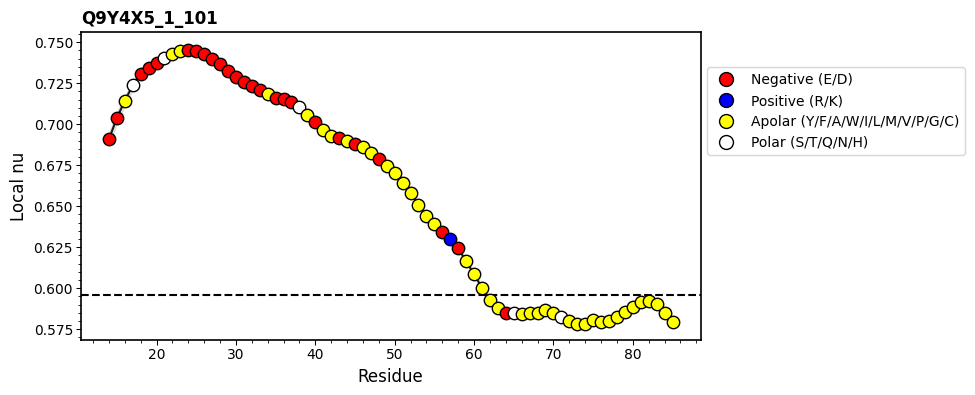

In [75]:
subchain_nu_plot(subchain_random_6,8,4)

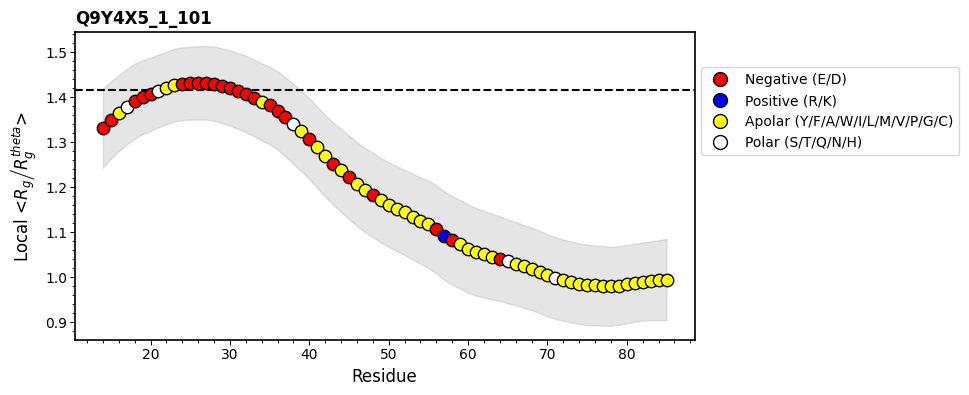

In [76]:
subchain_Rg_Rg_theta_mean_plot(subchain_random_6,8,4)

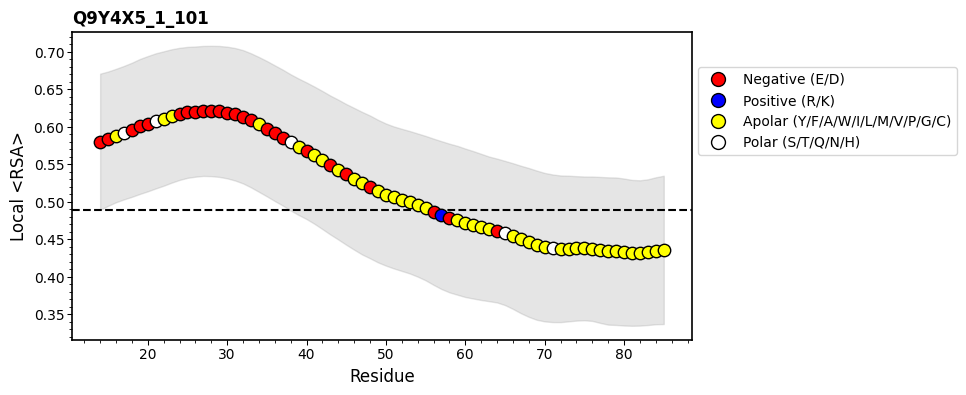

In [77]:
subchain_RSA_plot(subchain_random_6,8,4)

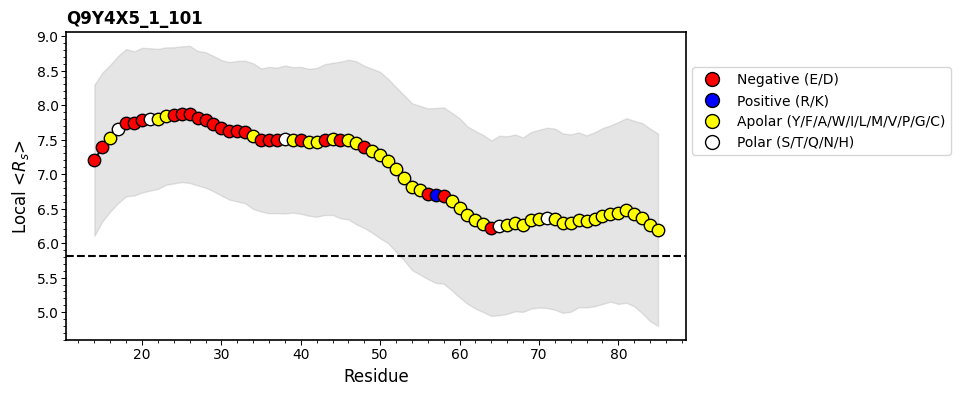

In [78]:
subchain_Rs_plot(subchain_random_6,8,4)

In [99]:
del subchain_random_6

In [103]:
idrome_prop_flucs[(idrome_prop_flucs['stdev_mean_RSA']<=0.01) & (idrome_prop_flucs.N>100)]

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,min_mean_nu,mid_res_min_mean_nu,max_mean_nu,mid_res_max_mean_nu,stdev_mean_nu,glob_loc_fac_RSA,glob_loc_fac_Rs,glob_loc_fac_rg_theta_mean,SM_RSA,SM_Rs
39,A0A0U1RQF7_1_123,A0A0U1RQF7,123,0.504,10.013685,5.885319,0.829512,0.225045,3.082066,7.118880,...,0.555201,52.0,0.593888,95.0,0.008441,-1.684097,-0.477610,1.473220,3.626150,5.025255
48,A0A0U1RRK4_1_108,A0A0U1RRK4,108,0.549,10.132748,6.399574,0.885686,0.193177,2.971231,7.152840,...,0.577490,49.0,0.597912,91.0,0.005570,-0.561981,0.116983,1.698370,3.440203,4.778534
64,A0A1B0GTR4_1_108,A0A1B0GTR4,108,0.550,10.224722,6.396816,0.874141,0.204934,3.068549,7.405599,...,0.580566,35.0,0.615718,90.0,0.008017,-1.177933,-0.388281,4.099330,3.754074,5.023441
88,A0A1B0GUT2_1_108,A0A1B0GUT2,108,0.531,10.029711,6.016011,0.920769,0.215761,2.934719,6.830998,...,0.559135,20.0,0.589306,79.0,0.007661,-0.593128,-0.566222,2.022845,3.923556,4.472407
117,A0A1B0GW64_1_132,A0A1B0GW64,132,0.518,10.153566,6.026780,0.829755,0.208014,3.298882,7.743057,...,0.549582,20.0,0.623444,113.0,0.016424,-0.619452,-0.102806,1.866925,5.120135,4.520274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27804,Q9Y5W7_685_791,Q9Y5W7,107,0.531,10.138280,6.159923,0.945916,0.218530,3.020139,7.106677,...,0.567068,14.0,0.601479,42.0,0.007813,-1.051395,-0.767693,3.228437,3.581325,3.613603
27808,Q9Y5W8_684_794,Q9Y5W8,111,0.535,10.126459,6.304615,0.903333,0.227166,3.062708,7.272038,...,0.576081,52.0,0.603290,92.0,0.007675,-1.751900,-0.445313,2.317231,3.362677,4.983120
27834,Q9Y5Z7_391_612,Q9Y5Z7,222,0.547,10.063232,6.260318,0.902714,0.233078,4.647436,11.114053,...,0.580941,19.0,0.620015,125.0,0.009208,-0.612304,-0.229540,3.023160,4.875274,5.312594
27925,Q9Y6G9_321_523,Q9Y6G9,203,0.525,9.999591,5.959100,0.955334,0.230190,4.231659,9.785881,...,0.564258,43.0,0.612767,120.0,0.012267,-0.900091,-0.642183,1.885081,4.550914,4.603920


In [104]:
subchain_random_7 = compute_30mer_data_from_seq_name_no_hdf5('A0A0U1RRK4_1_108',3)

residue 0 to 29 done
residue 1 to 30 done
residue 2 to 31 done
residue 3 to 32 done
residue 4 to 33 done
residue 5 to 34 done
residue 6 to 35 done
residue 7 to 36 done
residue 8 to 37 done
residue 9 to 38 done
residue 10 to 39 done
residue 11 to 40 done
residue 12 to 41 done
residue 13 to 42 done
residue 14 to 43 done
residue 15 to 44 done
residue 16 to 45 done
residue 17 to 46 done
residue 18 to 47 done
residue 19 to 48 done
residue 20 to 49 done
residue 21 to 50 done
residue 22 to 51 done
residue 23 to 52 done
residue 24 to 53 done
residue 25 to 54 done
residue 26 to 55 done
residue 27 to 56 done
residue 28 to 57 done
residue 29 to 58 done
residue 30 to 59 done
residue 31 to 60 done
residue 32 to 61 done
residue 33 to 62 done
residue 34 to 63 done
residue 35 to 64 done
residue 36 to 65 done
residue 37 to 66 done
residue 38 to 67 done
residue 39 to 68 done
residue 40 to 69 done
residue 41 to 70 done
residue 42 to 71 done
residue 43 to 72 done
residue 44 to 73 done
residue 45 to 74 don

In [105]:
subchain_random_7['mid_residue'] = (subchain_random_7['start_res_zeroindex'] + subchain_random_7['end_res_zeroindex']) // 2
subchain_stats_rsa = subchain_random_7.groupby('mid_residue').agg({
        'RSA': ['mean', 'std']}).reset_index()
subchain_random_7_SM_RSA = (subchain_stats_rsa['RSA']['mean'].max() - subchain_stats_rsa['RSA']['mean'].min())/(subchain_stats_rsa['RSA']['std'].mean())
subchain_stats_rs = subchain_random_7.groupby('mid_residue').agg({
        'inst_ratio': ['mean', 'std']}).reset_index()
subchain_random_7_SM_Rs = (subchain_stats_rs['inst_ratio']['mean'].max() - subchain_stats_rs['inst_ratio']['mean'].min())/(subchain_stats_rs['inst_ratio']['std'].mean())
subchain_random_7_SM_RSA

0.1593989370039362

In [106]:
subchain_random_7_SM_Rs

0.21775979582427668

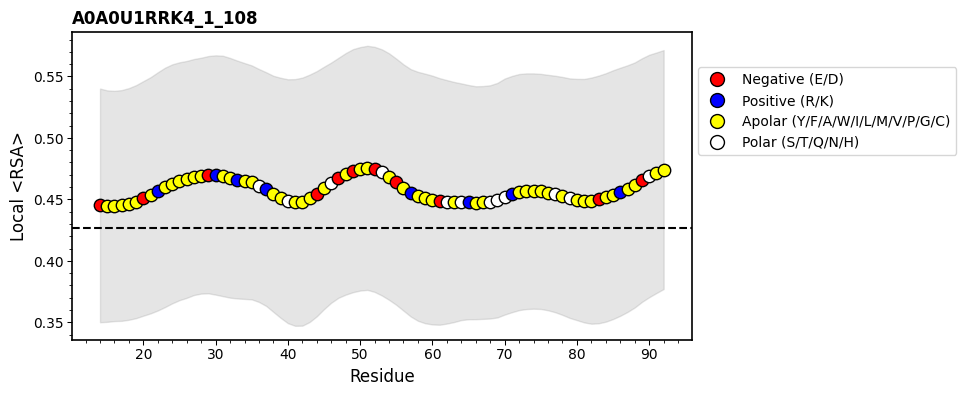

In [107]:
subchain_RSA_plot(subchain_random_7,8,4)

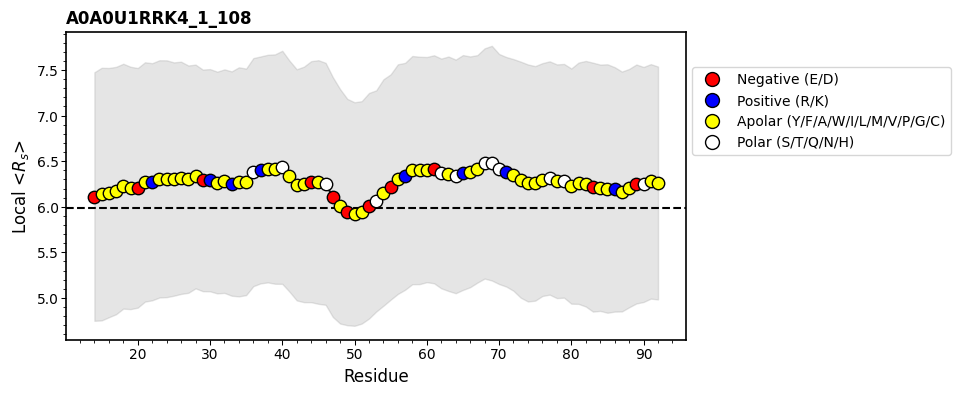

In [108]:
subchain_Rs_plot(subchain_random_7,8,4)